# <span style='font-family:"Times New Roman"'> <span styel=''>**METRICS ANALYSIS**
*Emile Cohen*
    
 *April 2020*

**Goal:** In this notebook, we compute panels for specific metrics across all cancer types.

The notebook is composed of 2 parts:
   * **Subgroup Proportion**
   * **Number of aberrant chromosomes**
---

In [1]:
%run -i '../../../utils/setup_environment.ipy'

import warnings
warnings.filterwarnings('ignore')
from scipy.stats import fisher_exact, ranksums, chi2, norm
from statsmodels.sandbox.stats.multicomp import multipletests
import matplotlib.gridspec as gridspec
from itertools import cycle, islice

data_path = '../../../data/'

Setup environment... done!


<span style="color:green">✅ Working on **mskimpact_env** conda environment.</span>

In [2]:
cancer_type = 'Non-Small Cell Lung Cancer'
mc = list(islice(cycle(list(sns.color_palette("muted"))), None, 6))
palette ={'>=1_LOSS':mc[0], 'HOMDEL':mc[1], '1_WILD_TYPE':mc[2], '>1muts':mc[3], '>=1_cnLOH':mc[4], '0_HETLOSS':mc[5]}
palette_list = [mc[5],mc[2],mc[3],mc[4],mc[0],mc[1]]
group_list = ['0_HETLOSS', '1_WILD_TYPE', '>1muts', '>=1_cnLOH', '>=1_LOSS','HOMDEL']
master = load_clean_up_master(data_path + 'merged_data/master_file.pkl')
# We remove INDETERMINATE and NaN tp53_cn_state samples
master_cancer = master[master['Cancer_Type'] == cancer_type][master['tp53_cn_state'] != 'INDETERMINATE'][~master['tp53_cn_state'].isna()]

---
# Subgroup Proportion

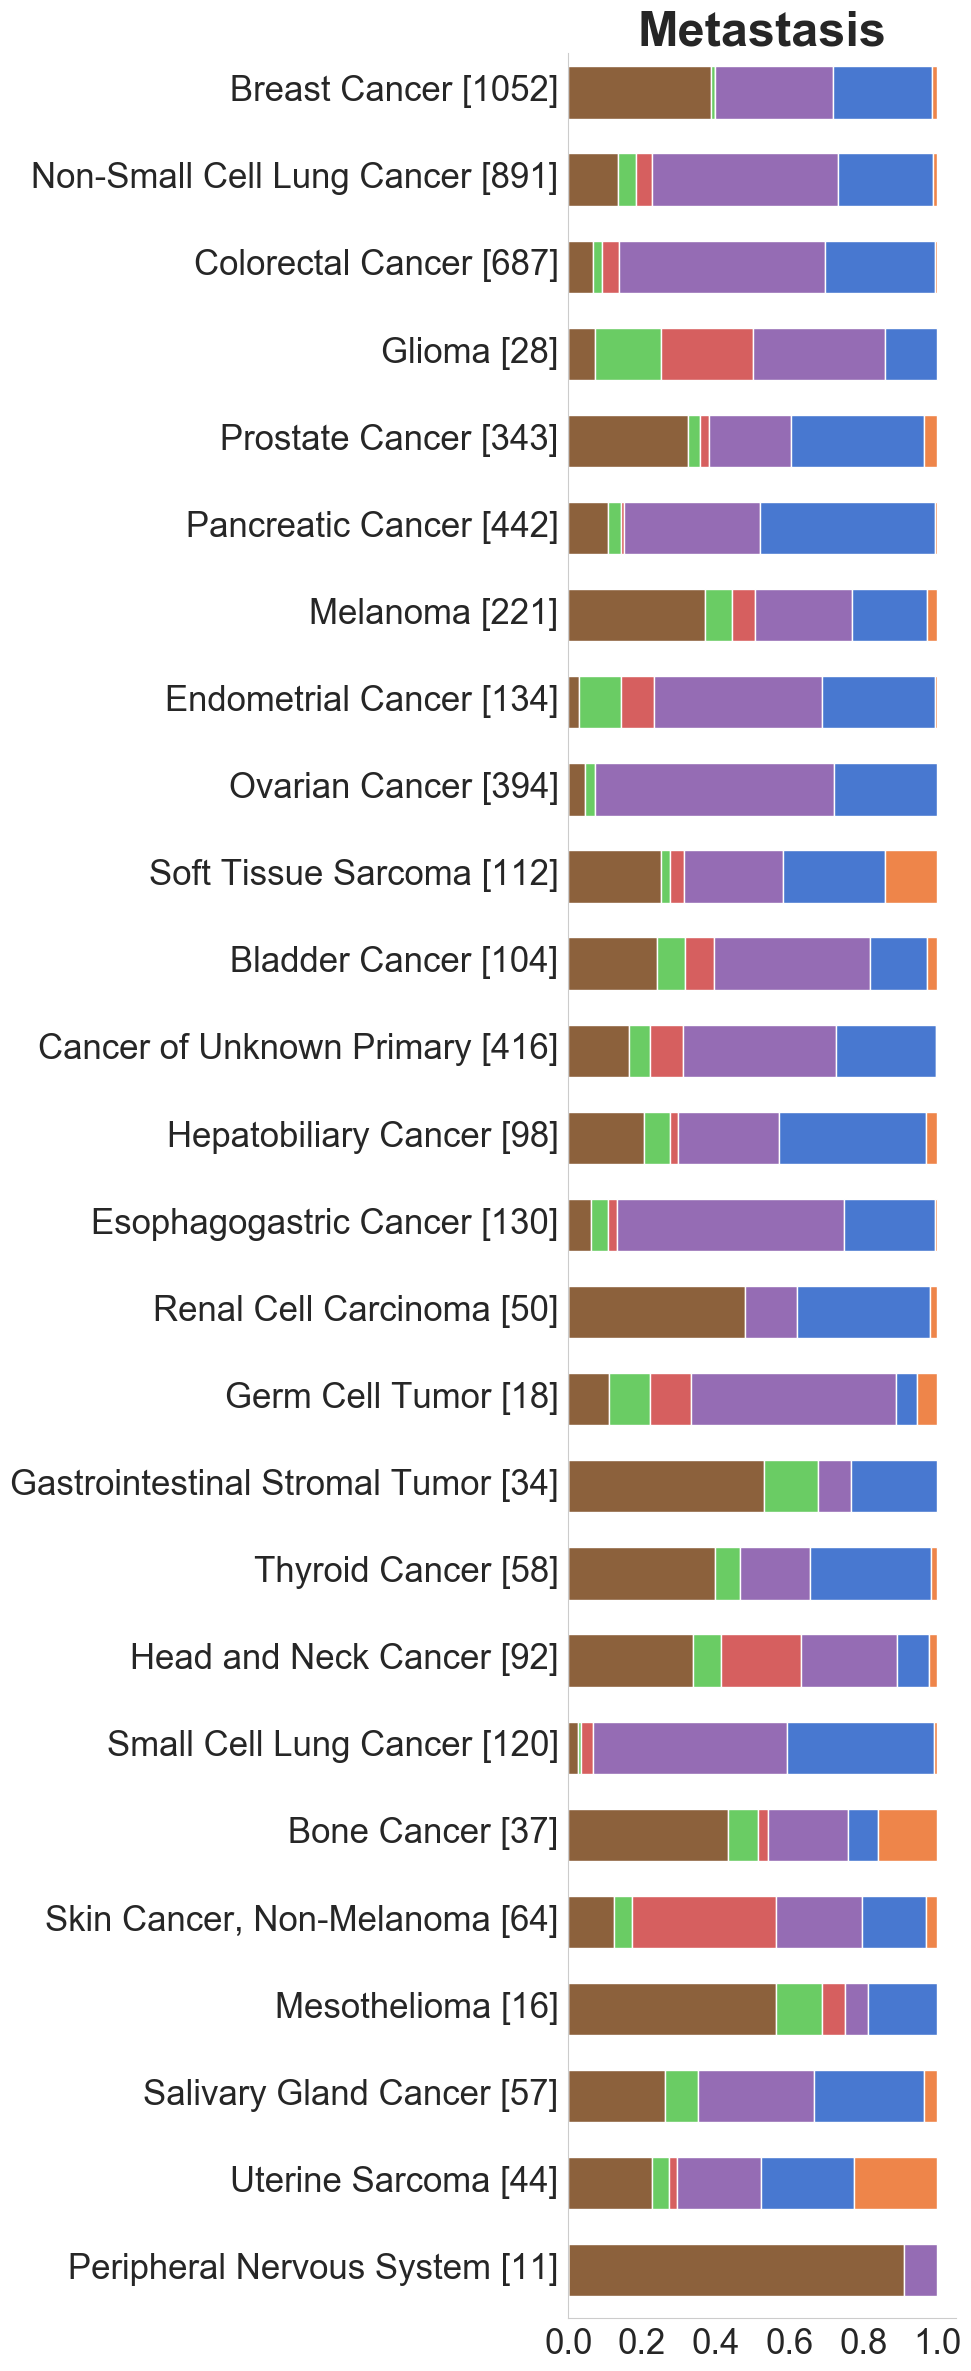

In [3]:
sns.set_style("whitegrid", {'grid.color': '1.'})
cancer_count = get_groupby(master, 'Cancer_Type', 'count').sort_values(by='count', ascending = False)
cancer_list = list(cancer_count[cancer_count['count']>=200].index.values)
prim_met = 'Metastasis'
metrics='tp53_group'
fig, ax = plt.subplots(figsize=(5,30))

def plot_metrics_cancerlist(master: pd.DataFrame, metrics: str, prim_met: str, ax,  legend=True):
    for i, cancer_type in enumerate(cancer_list):
        master_cancer = master[master['Cancer_Type'] == cancer_type][master['tp53_cn_state'] != 'INDETERMINATE'][~master['tp53_cn_state'].isna()]
        count_prim_met = get_groupby(master_cancer[master_cancer['Sample_Type'] == prim_met], metrics, 'count_prim_met' + metrics)
        freq_prim_met = pd.DataFrame(count_prim_met['count_prim_met' + metrics]).sort_values(by=['count_prim_met' + metrics], ascending=False)/ pd.DataFrame(count_prim_met['count_prim_met' + metrics]).sum()
        if legend:
            freq_prim_met.columns=[cancer_type + ' ' + str(pd.DataFrame(count_prim_met['count_prim_met' + metrics]).sum().values)]
        else:
            freq_prim_met.columns=[str(pd.DataFrame(count_prim_met['count_prim_met' + metrics]).sum().values)]
        freq_prim_met = freq_prim_met.reindex(group_list)
        if i==0:
            freq_prim_met_final = freq_prim_met.T
        else : freq_prim_met_final = pd.concat([freq_prim_met_final, freq_prim_met.T], axis=0)

    freq_prim_met_final = freq_prim_met_final.fillna(0)

    h = freq_prim_met_final[::-1].plot(kind = 'barh', stacked=True, ax=ax, yticks=[0,0.25,0.5,0.75,1], color=palette_list)

    ax.set_title(prim_met, weight = 'bold', fontsize=35)
    ax.legend_.remove()

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    

    for container in ax.containers:
        for i, child in enumerate(container.get_children()):
            child.set_height(0.6)

    ax.set_yticks([k + 0.1 for k in list(range(len(cancer_list)))])
    
    #if legend == False:
    #h.axes.get_yaxis().set_ticks([])
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(25) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(25)
    
plot_metrics_cancerlist(master=master,
                        metrics=metrics, 
                        prim_met=prim_met, 
                        ax=ax,  
                        legend=True)

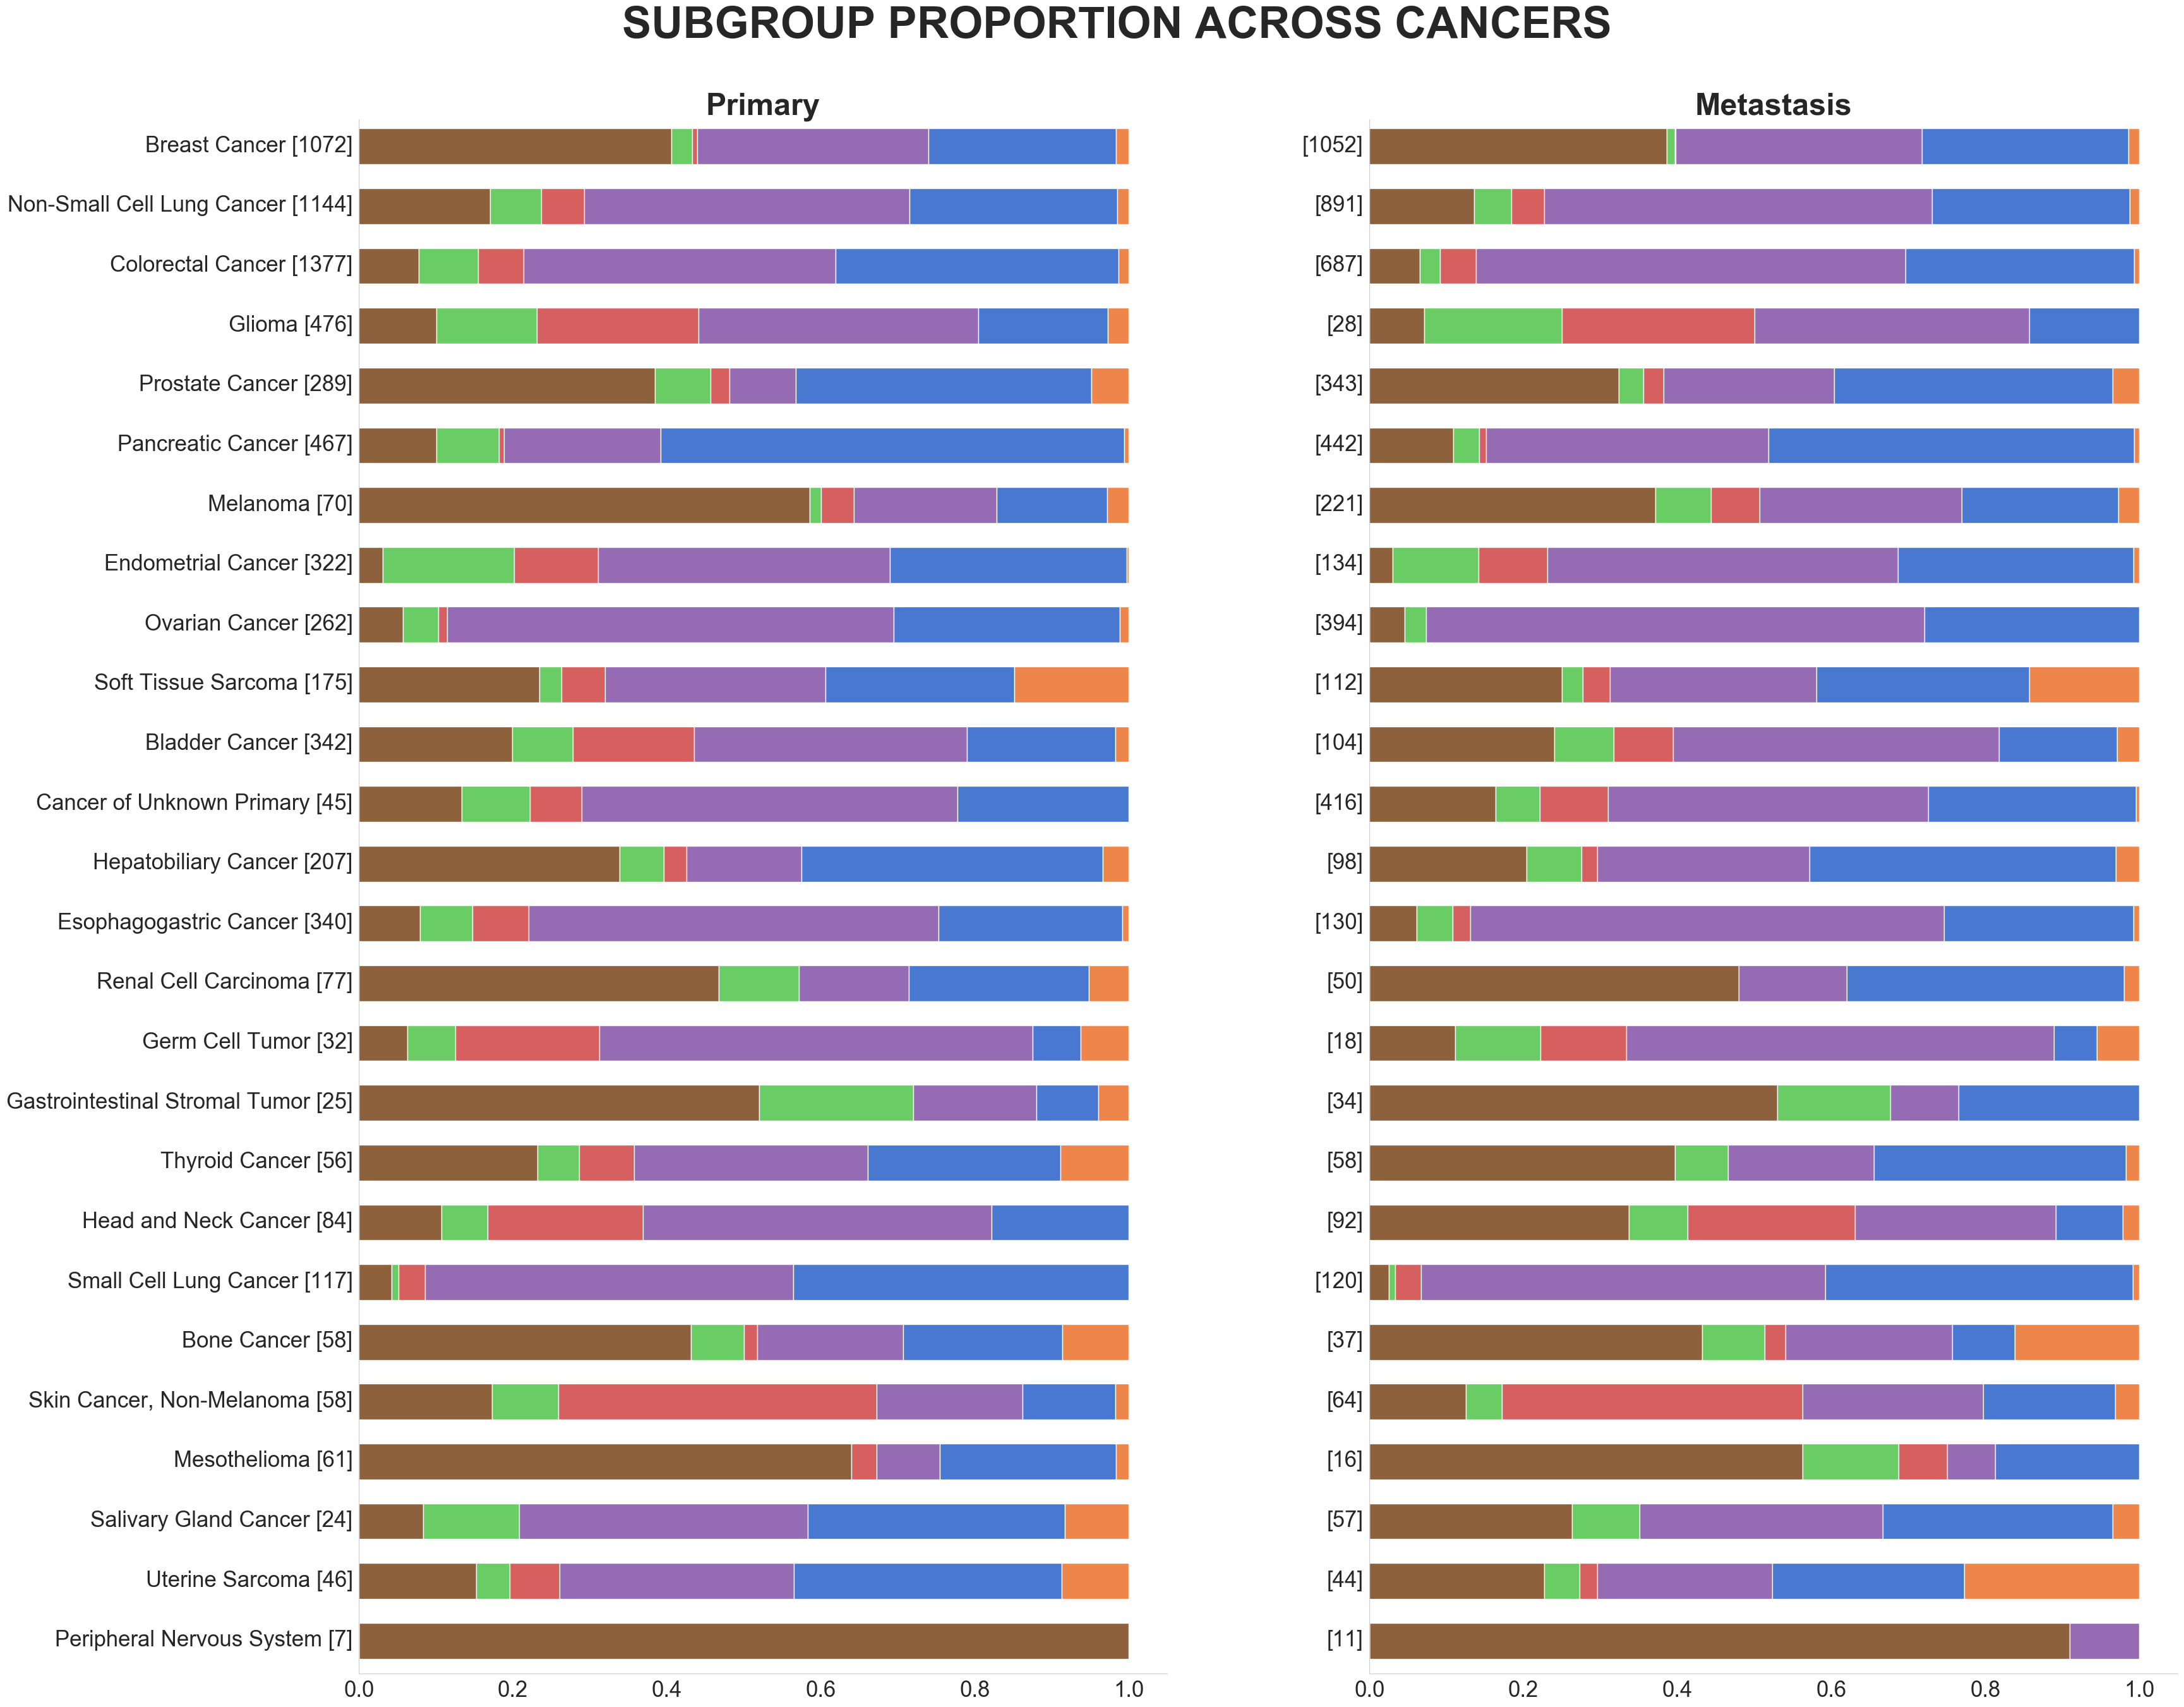

In [4]:
cancer_count = get_groupby(master, 'Cancer_Type', 'count').sort_values(by='count', ascending = False)
cancer_list = list(cancer_count[cancer_count['count']>=200].index.values)

fig = plt.figure(figsize=(40,30))
outer = gridspec.GridSpec(nrows=1, ncols=2)
inner = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=2, subplot_spec=outer[:1, :2],wspace=0.25, hspace=0)
ax_prim = plt.Subplot(fig, inner[0])
ax_met = plt.Subplot(fig, inner[1])

plot_metrics_cancerlist(master=master,
                        metrics='tp53_group', 
                        prim_met='Primary', 
                        ax=ax_prim,  
                        legend=True)

plot_metrics_cancerlist(master=master,
                        metrics='tp53_group', 
                        prim_met='Metastasis', 
                        ax=ax_met,  
                        legend=False)

fig.add_subplot(ax_prim)
fig.add_subplot(ax_met)

fig.subplots_adjust(left=0.2, bottom=0.10, right=0.92, top=0.92, wspace=1, hspace=1)
fig.suptitle('SUBGROUP PROPORTION ACROSS CANCERS', fontsize=50,fontweight='bold')
fig.savefig('./metrics_summaries/subgroup_proportions.pdf', format='pdf')

---
# Genome Instability Metrics

In [5]:
def style(ax1):
    for i, artist in enumerate(ax1.artists):
        # Set the linecolor on the artist to the facecolor, and set the facecolor to None
        artist.set_edgecolor('black')

        # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
        # Loop over them here, and use the same colour as above
        for j in range(i * 6, i * 6 + 6):
            line = ax1.lines[j]
            line.set_color('black')
            line.set_mfc('None')
            line.set_mec('None')

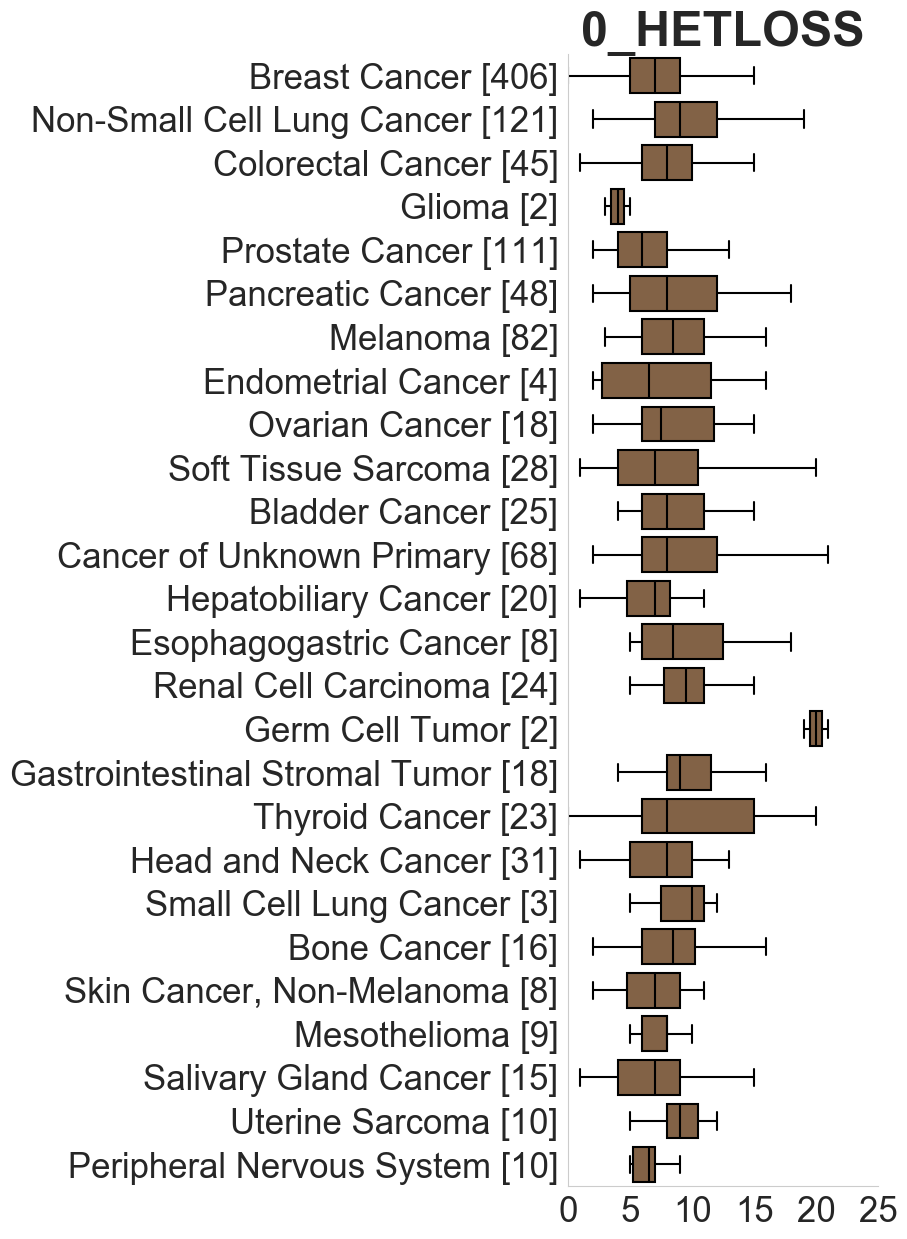

In [6]:
cancer_count = get_groupby(master, 'Cancer_Type', 'count').sort_values(by='count', ascending = False)
cancer_list = list(cancer_count[cancer_count['count']>=200].index.values)

group_choice= 'tp53_group'
group = '0_HETLOSS'
metrics = 'chr_affected'
title = cancer_type
prim_met='Metastasis'
xlim=25
legend=False

fig, ax = plt.subplots(figsize=(4,15))

def boxplot_cancertype(master: pd.DataFrame, group_choice: str, group: str, ax, metrics: str, prim_met: str, xlim=25, legend=True):
    master_group = master[master[group_choice] == group][master['tp53_cn_state'] != 'INDETERMINATE'][~master['tp53_cn_state'].isna()][master['Sample_Type'] == prim_met][master['Cancer_Type'].isin(cancer_list)]

    h=sns.boxplot(y='Cancer_Type',
                  x=metrics,
                  data=master_group,
                  ax=ax,
                  order=cancer_list,
                  color=palette_list[group_list.index(group)])


    style(ax)
    ax.set_xlabel('')
    ax.set_title(group, fontsize=35, weight='bold')
    ax.set_ylabel('')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    if legend:
        ax.set_yticklabels([str(cancer) + ' [' + str(master_group[master_group['Cancer_Type'] == cancer].shape[0]) +  ']' for cancer in cancer_list])
    else : 
        ax.set_yticklabels(['[' + str(master_group[master_group['Cancer_Type'] == cancer].shape[0]) +  ']' for cancer in cancer_list])
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(25) 
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(25) 

    ax.set_xlim(0, xlim)
    

boxplot_cancertype(master,
                   group_choice=group_choice,
                   group=group,
                   ax=ax,
                   metrics=metrics,
                   prim_met=prim_met,
                   xlim=25,
                   legend=True)


In [7]:
group_choice= 'tp53_group'
metrics = 'chr_affected'
title = cancer_type
prim_met='Metastasis'
xlim=25
title= 'Number of aberrant chromosomes - Metastatic Samples'

def panel_metrics(group_choice, metrics, title, prim_met, xlim):
    fig = plt.figure(figsize=(50,30))
    outer = gridspec.GridSpec(nrows=1, ncols=6)

    inner = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=6, subplot_spec=outer[0:1, :6],wspace=0.2, hspace=0)
    group_list = ['0_HETLOSS', '1_WILD_TYPE', '>1muts', '>=1_cnLOH', '>=1_LOSS','HOMDEL']
    palette_list = [mc[5],mc[2],mc[3],mc[4],mc[0],mc[1]]

    for i, group in enumerate(group_list):
        ax = plt.Subplot(fig, inner[i])
        if i == 0:
            boxplot_cancertype(master,
                       group_choice=group_choice,
                       group=group,
                       ax=ax,
                       metrics=metrics,
                       prim_met=prim_met,
                       xlim=xlim,
                       legend=True)
        else:
            boxplot_cancertype(master,
                       group_choice=group_choice,
                       group=group,
                       ax=ax,
                       metrics=metrics,
                       prim_met=prim_met,
                       xlim=xlim,
                       legend=False)
        fig.add_subplot(ax)

    fig.subplots_adjust(left=0.15, bottom=0.10, right=0.92, top=0.92, wspace=1, hspace=2)
    fig.suptitle(title, fontsize=50,fontweight='bold')
    fig.savefig('./metrics_summaries/{}_{}.pdf'.format(metrics, prim_met), format='pdf')

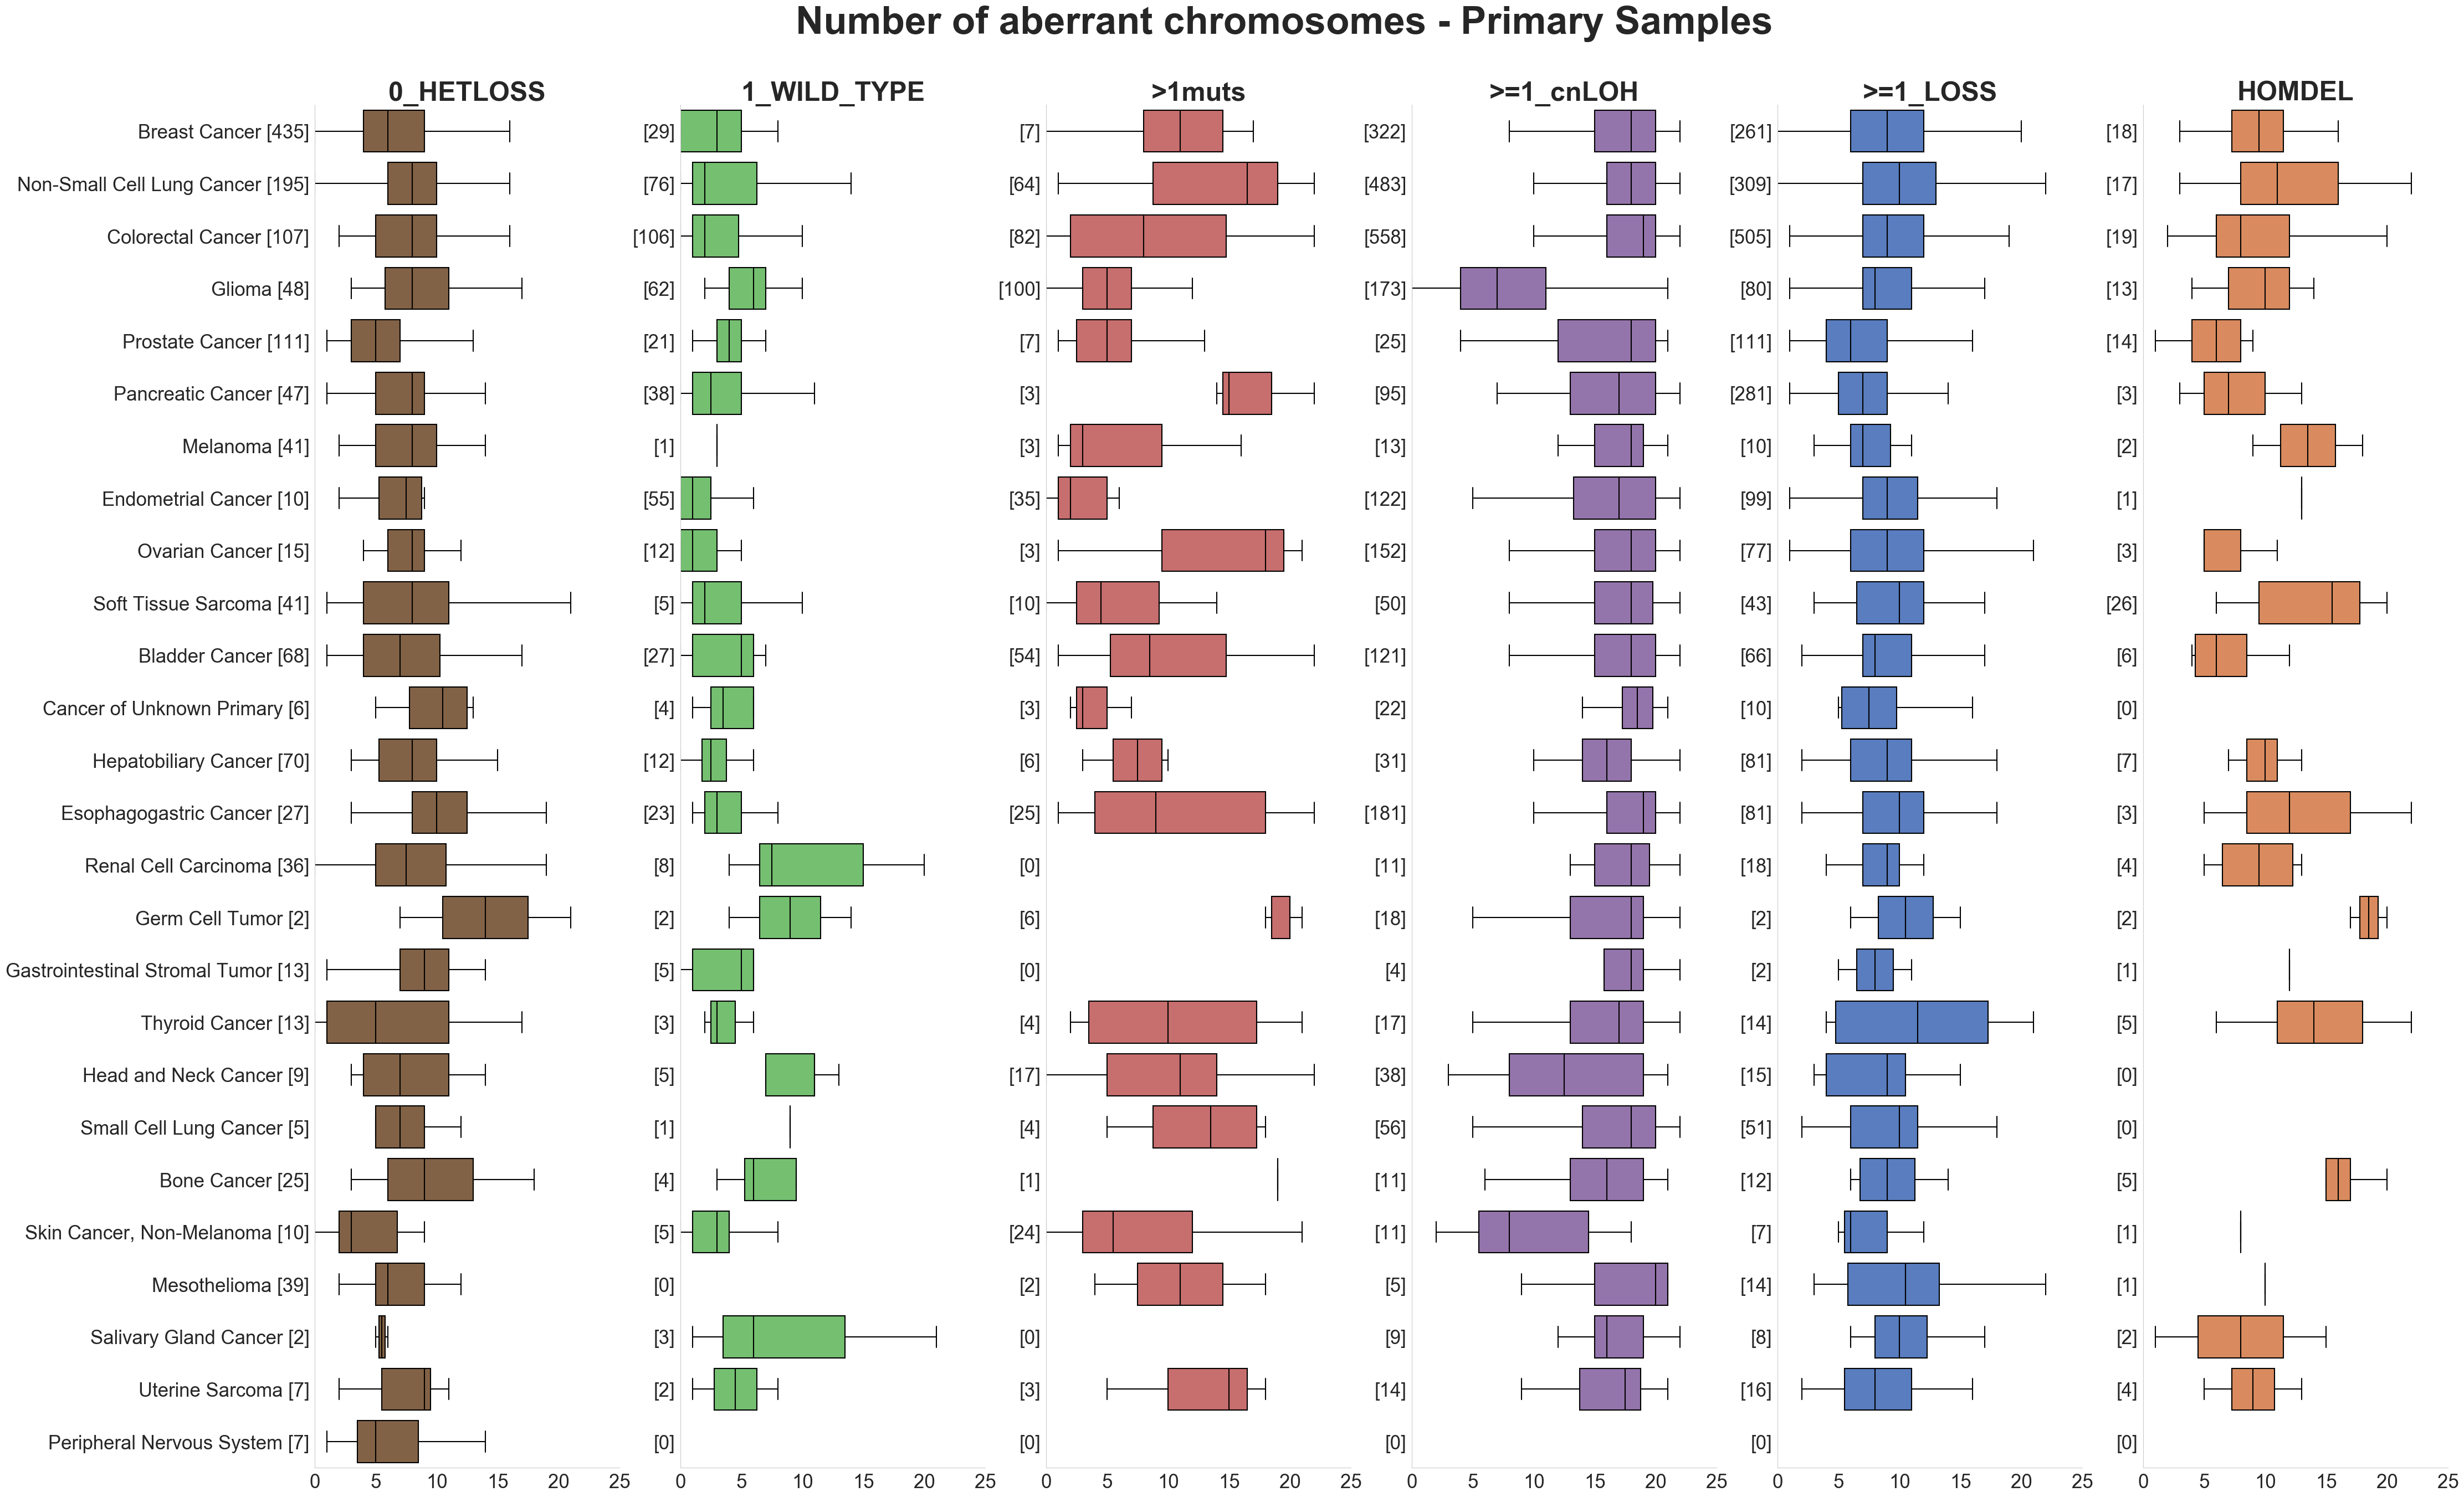

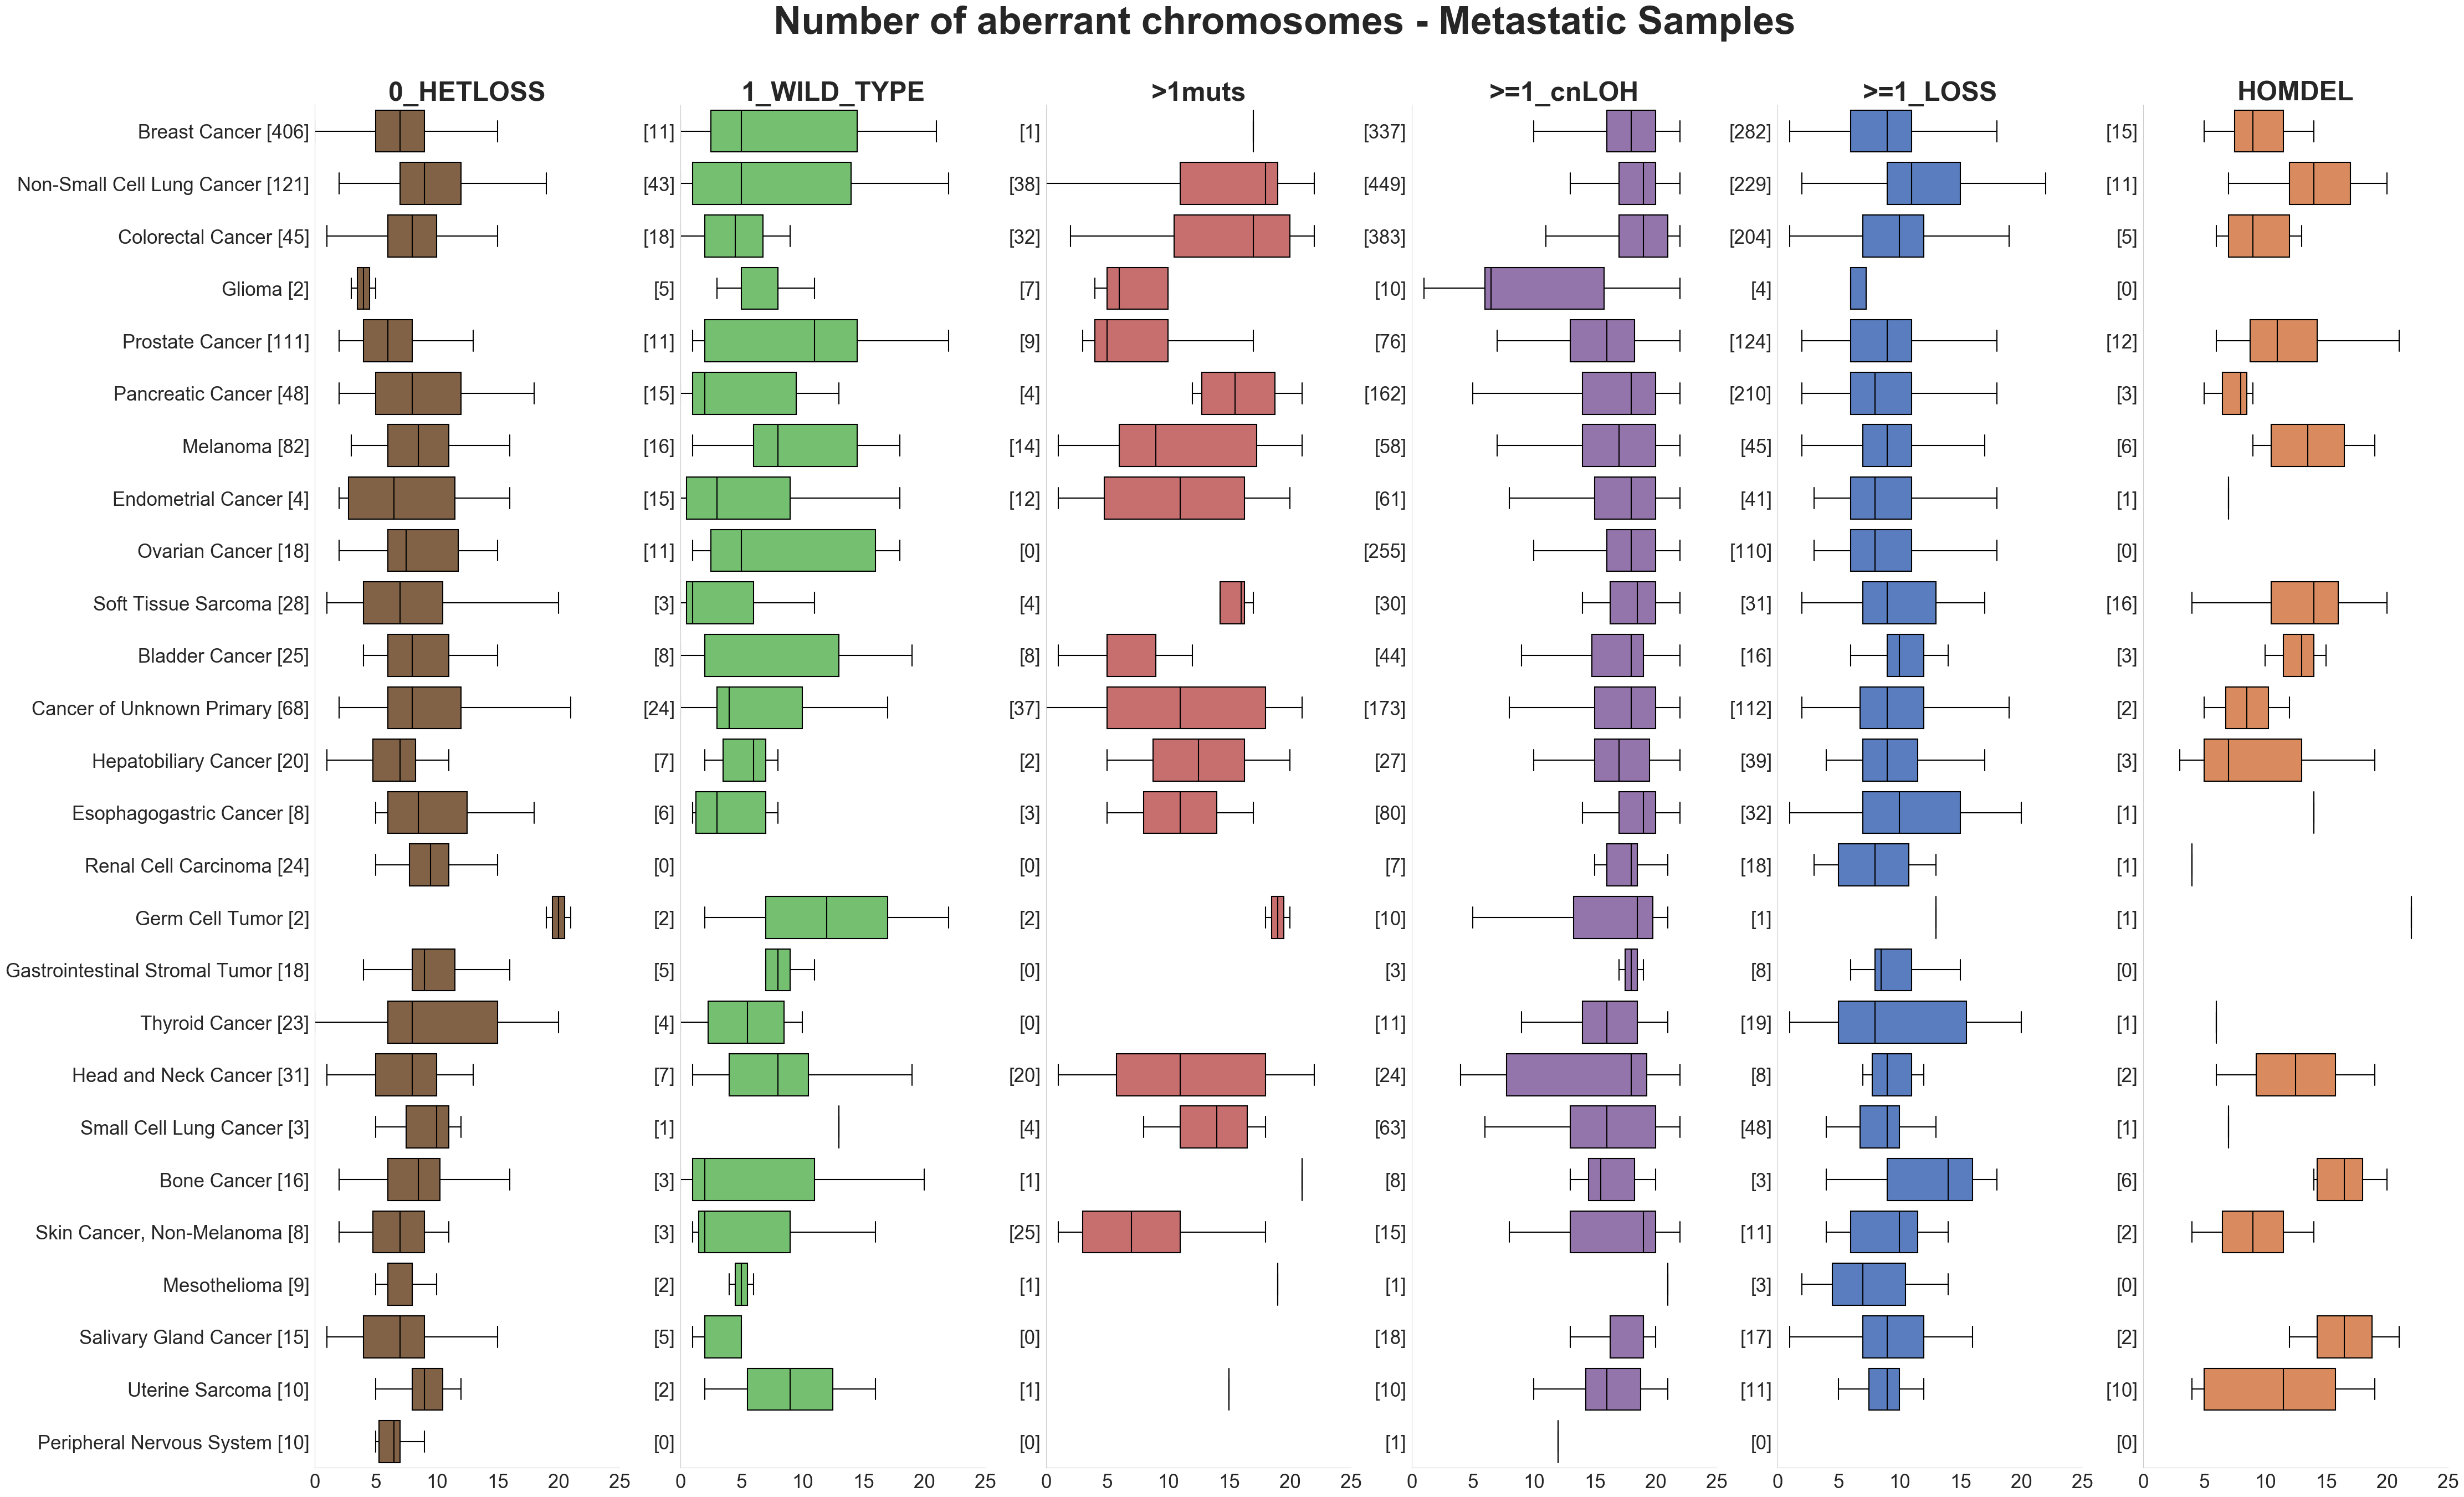

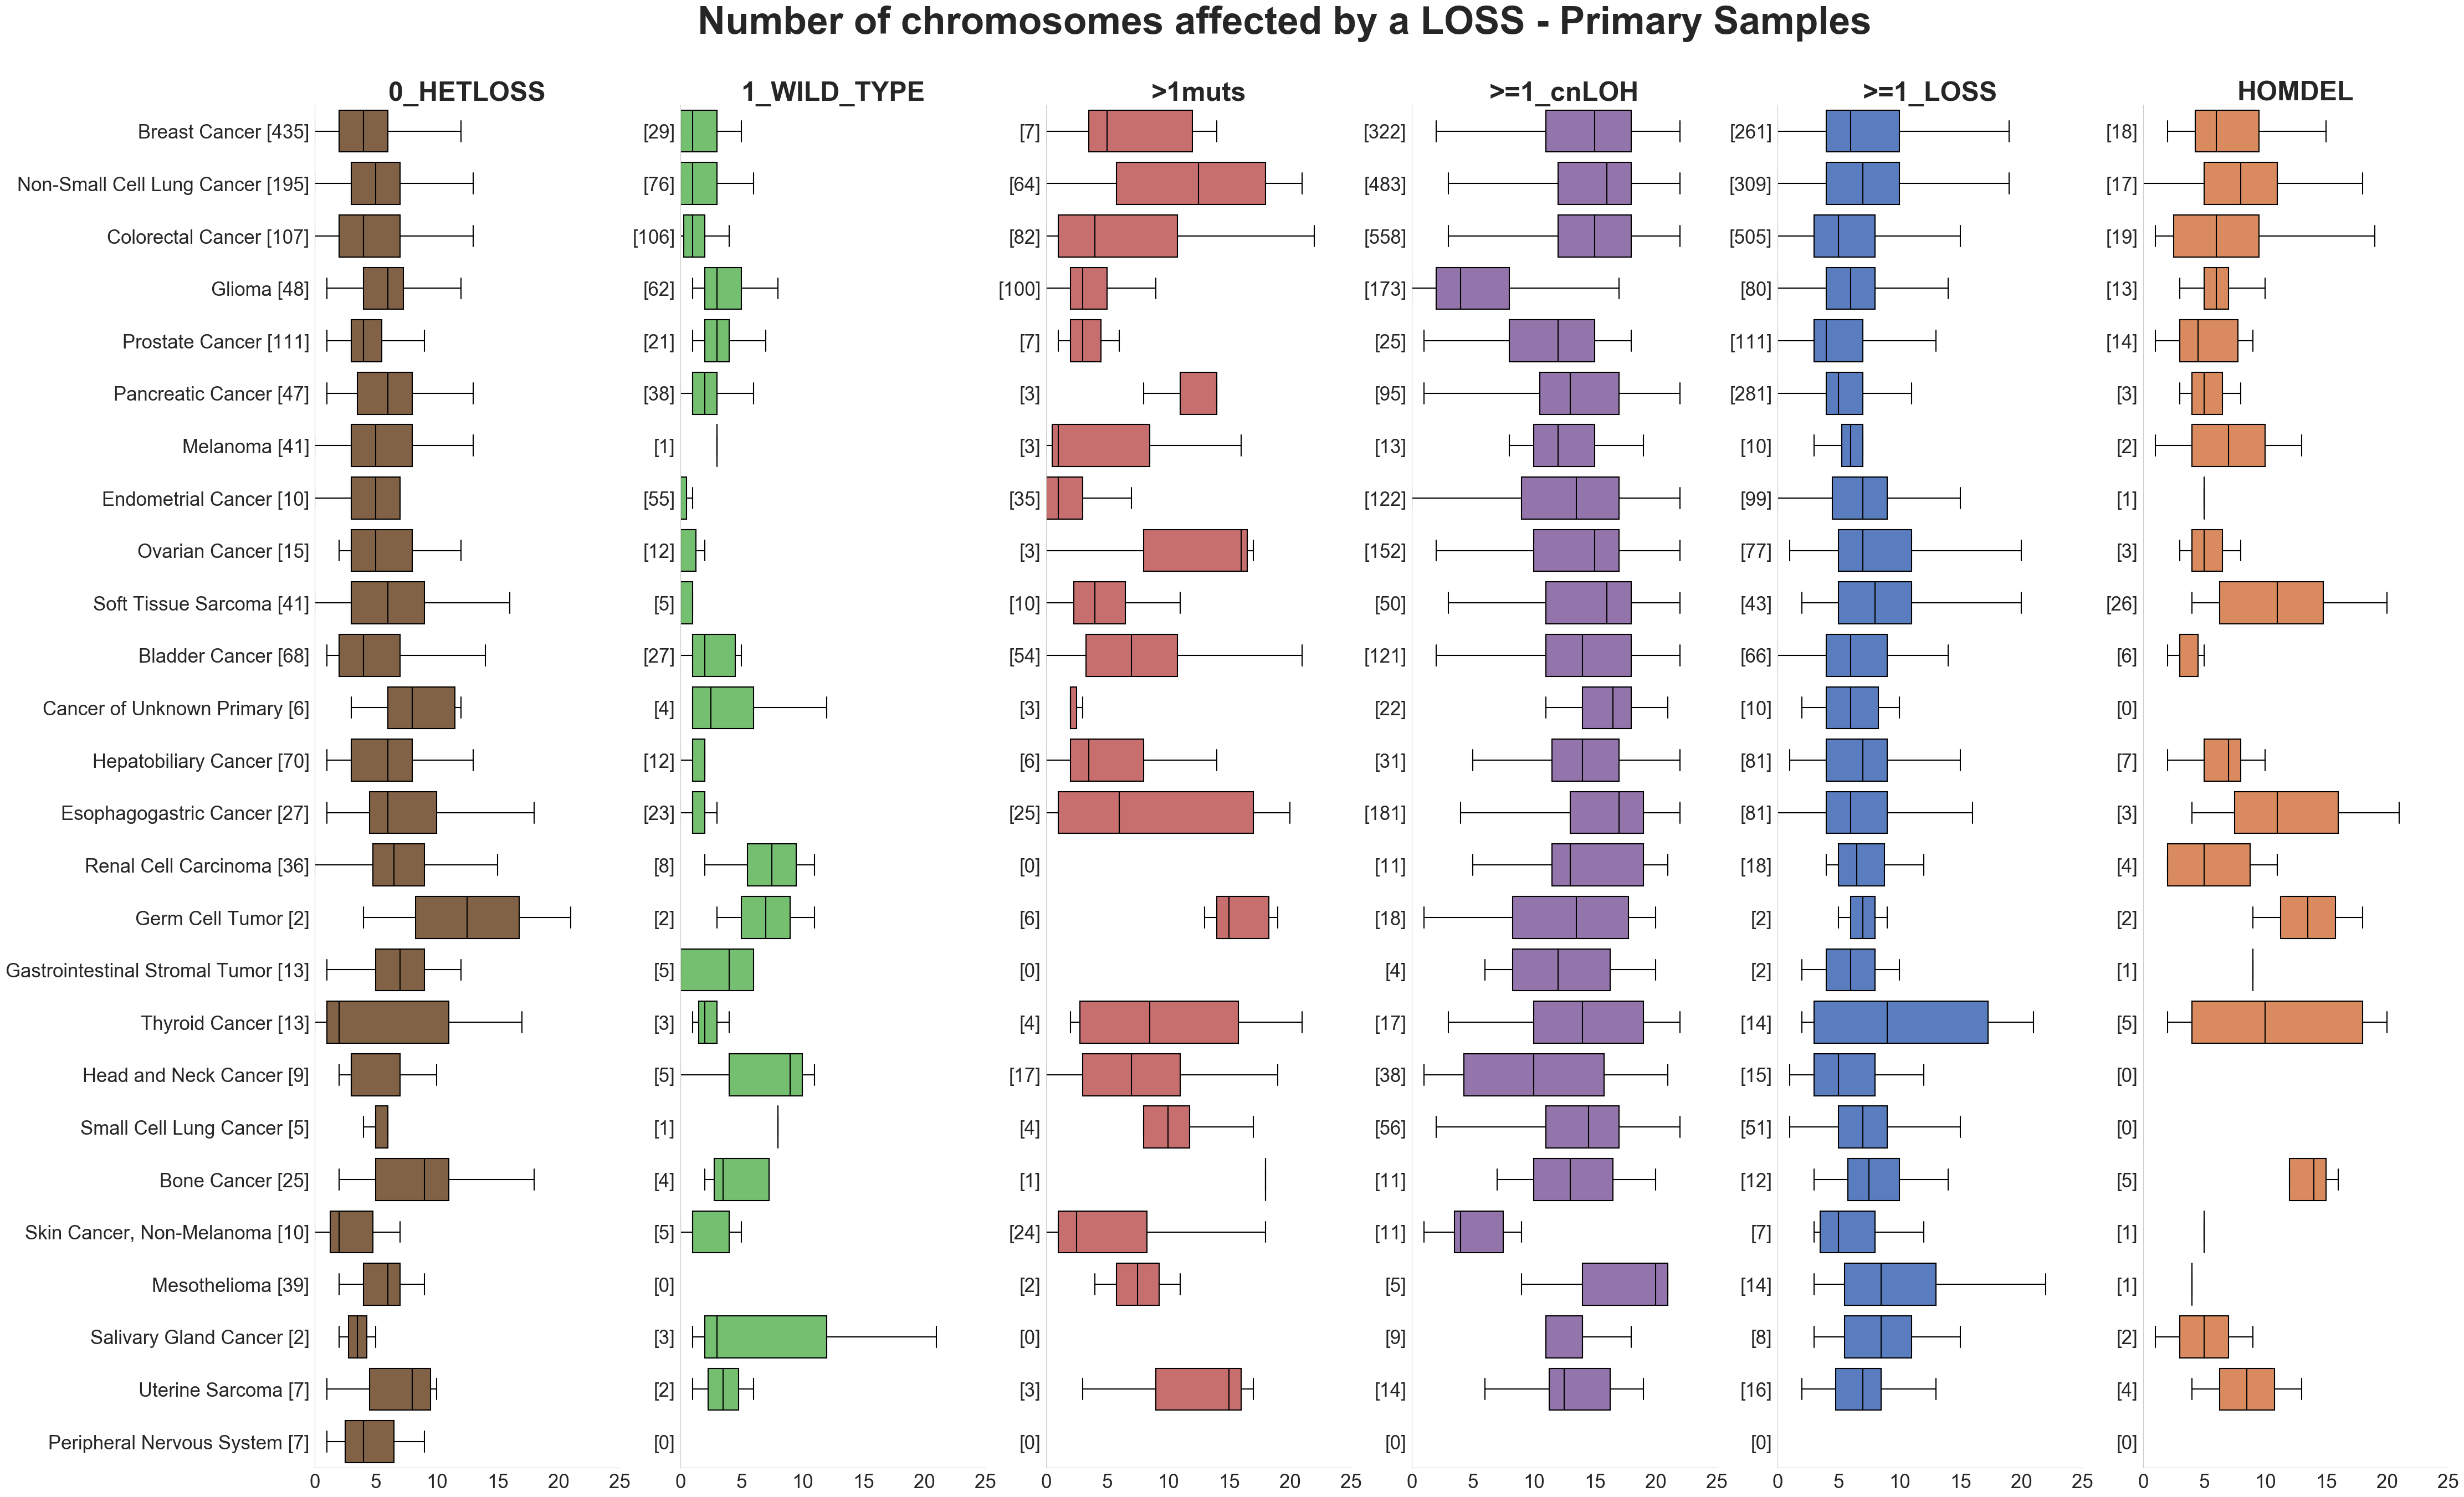

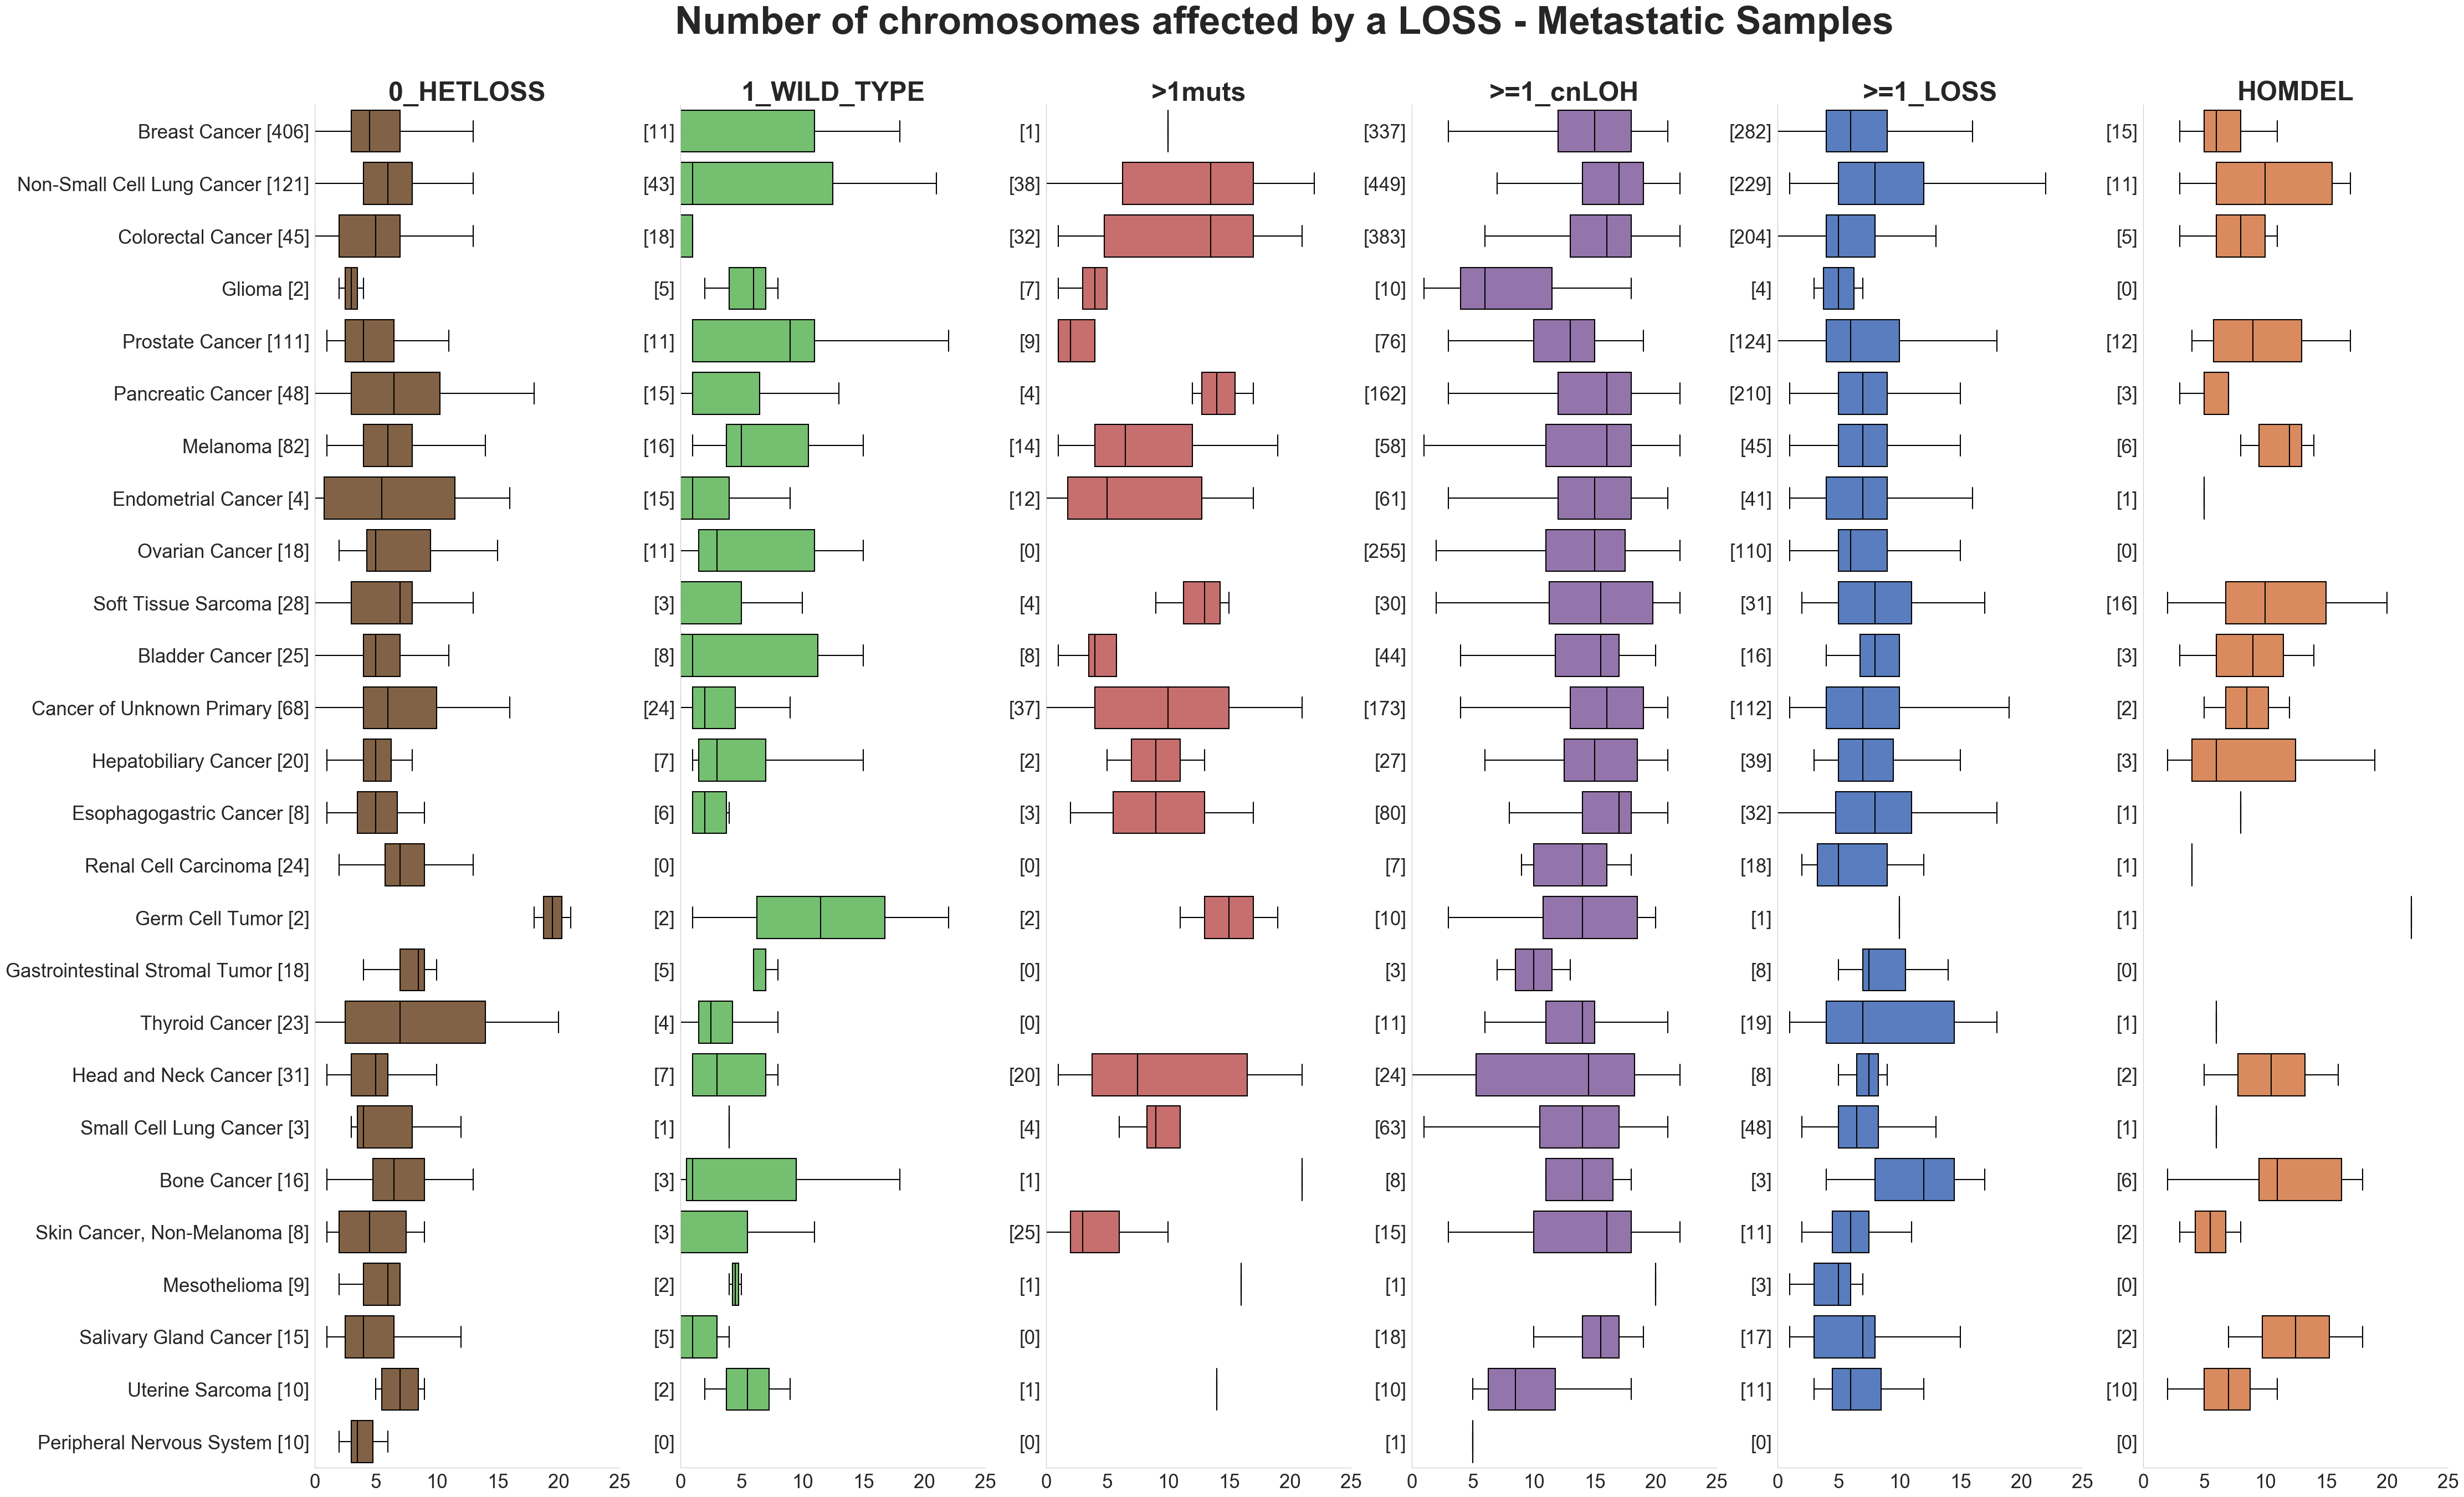

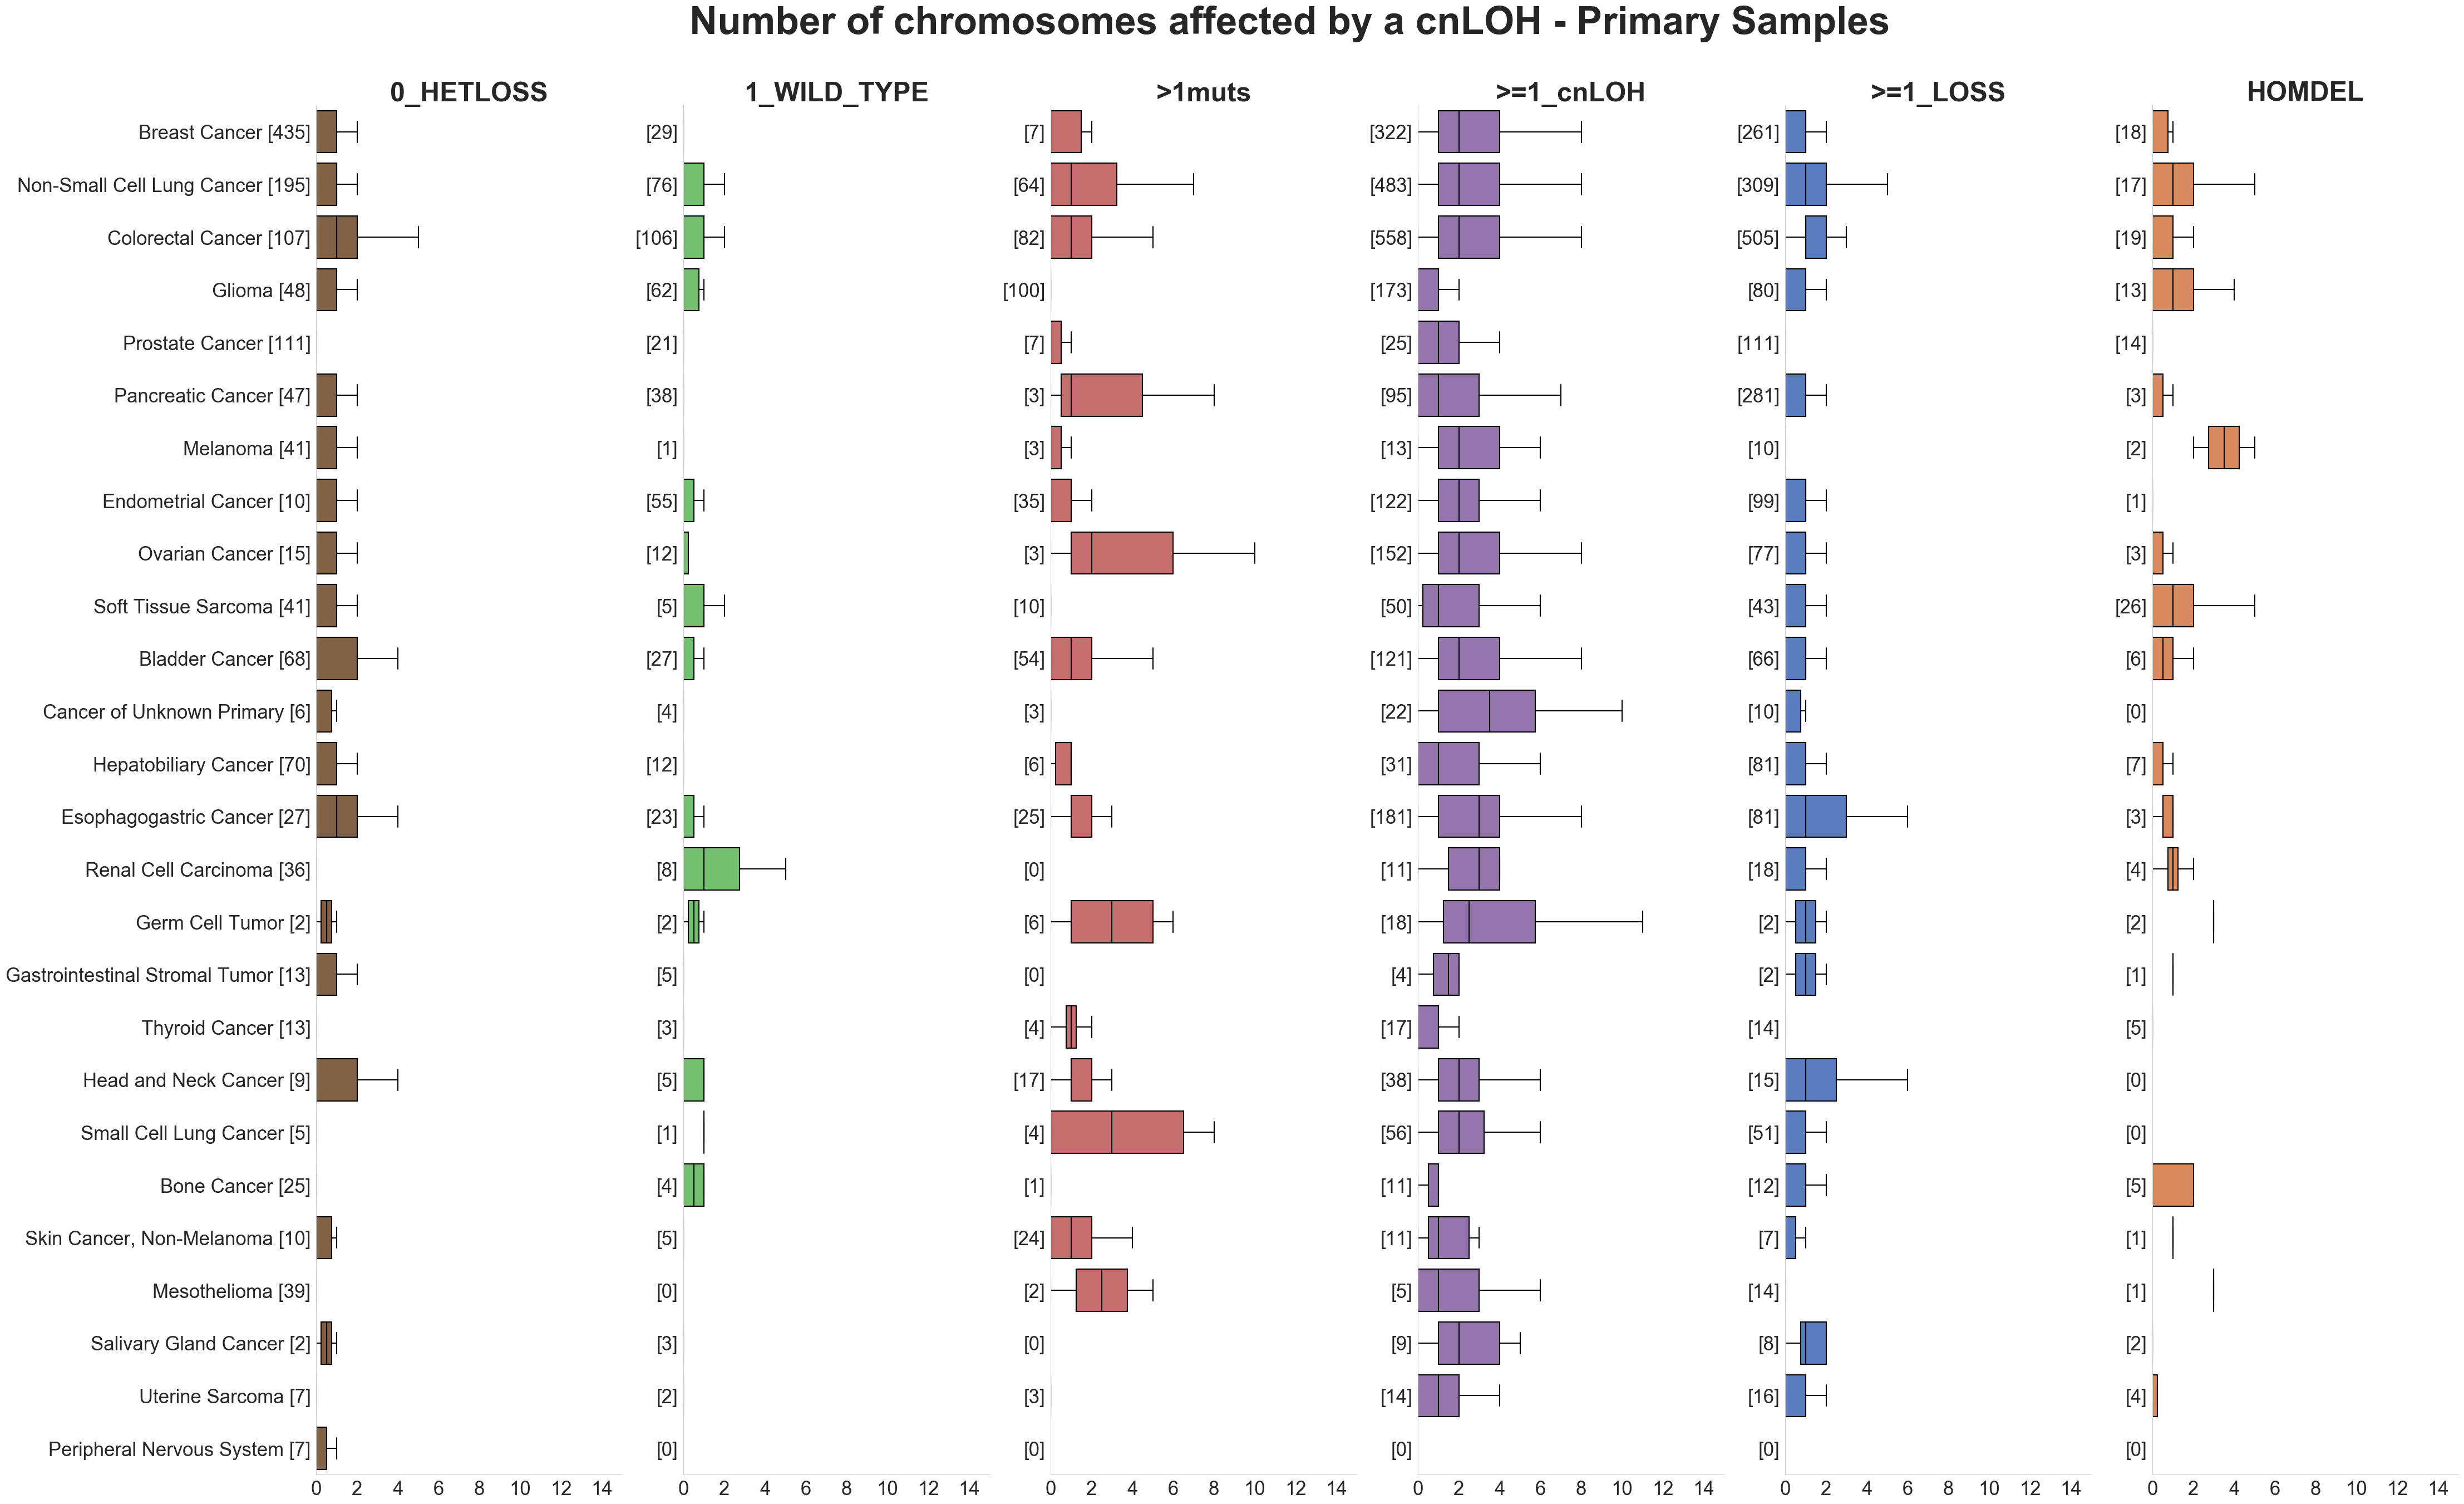

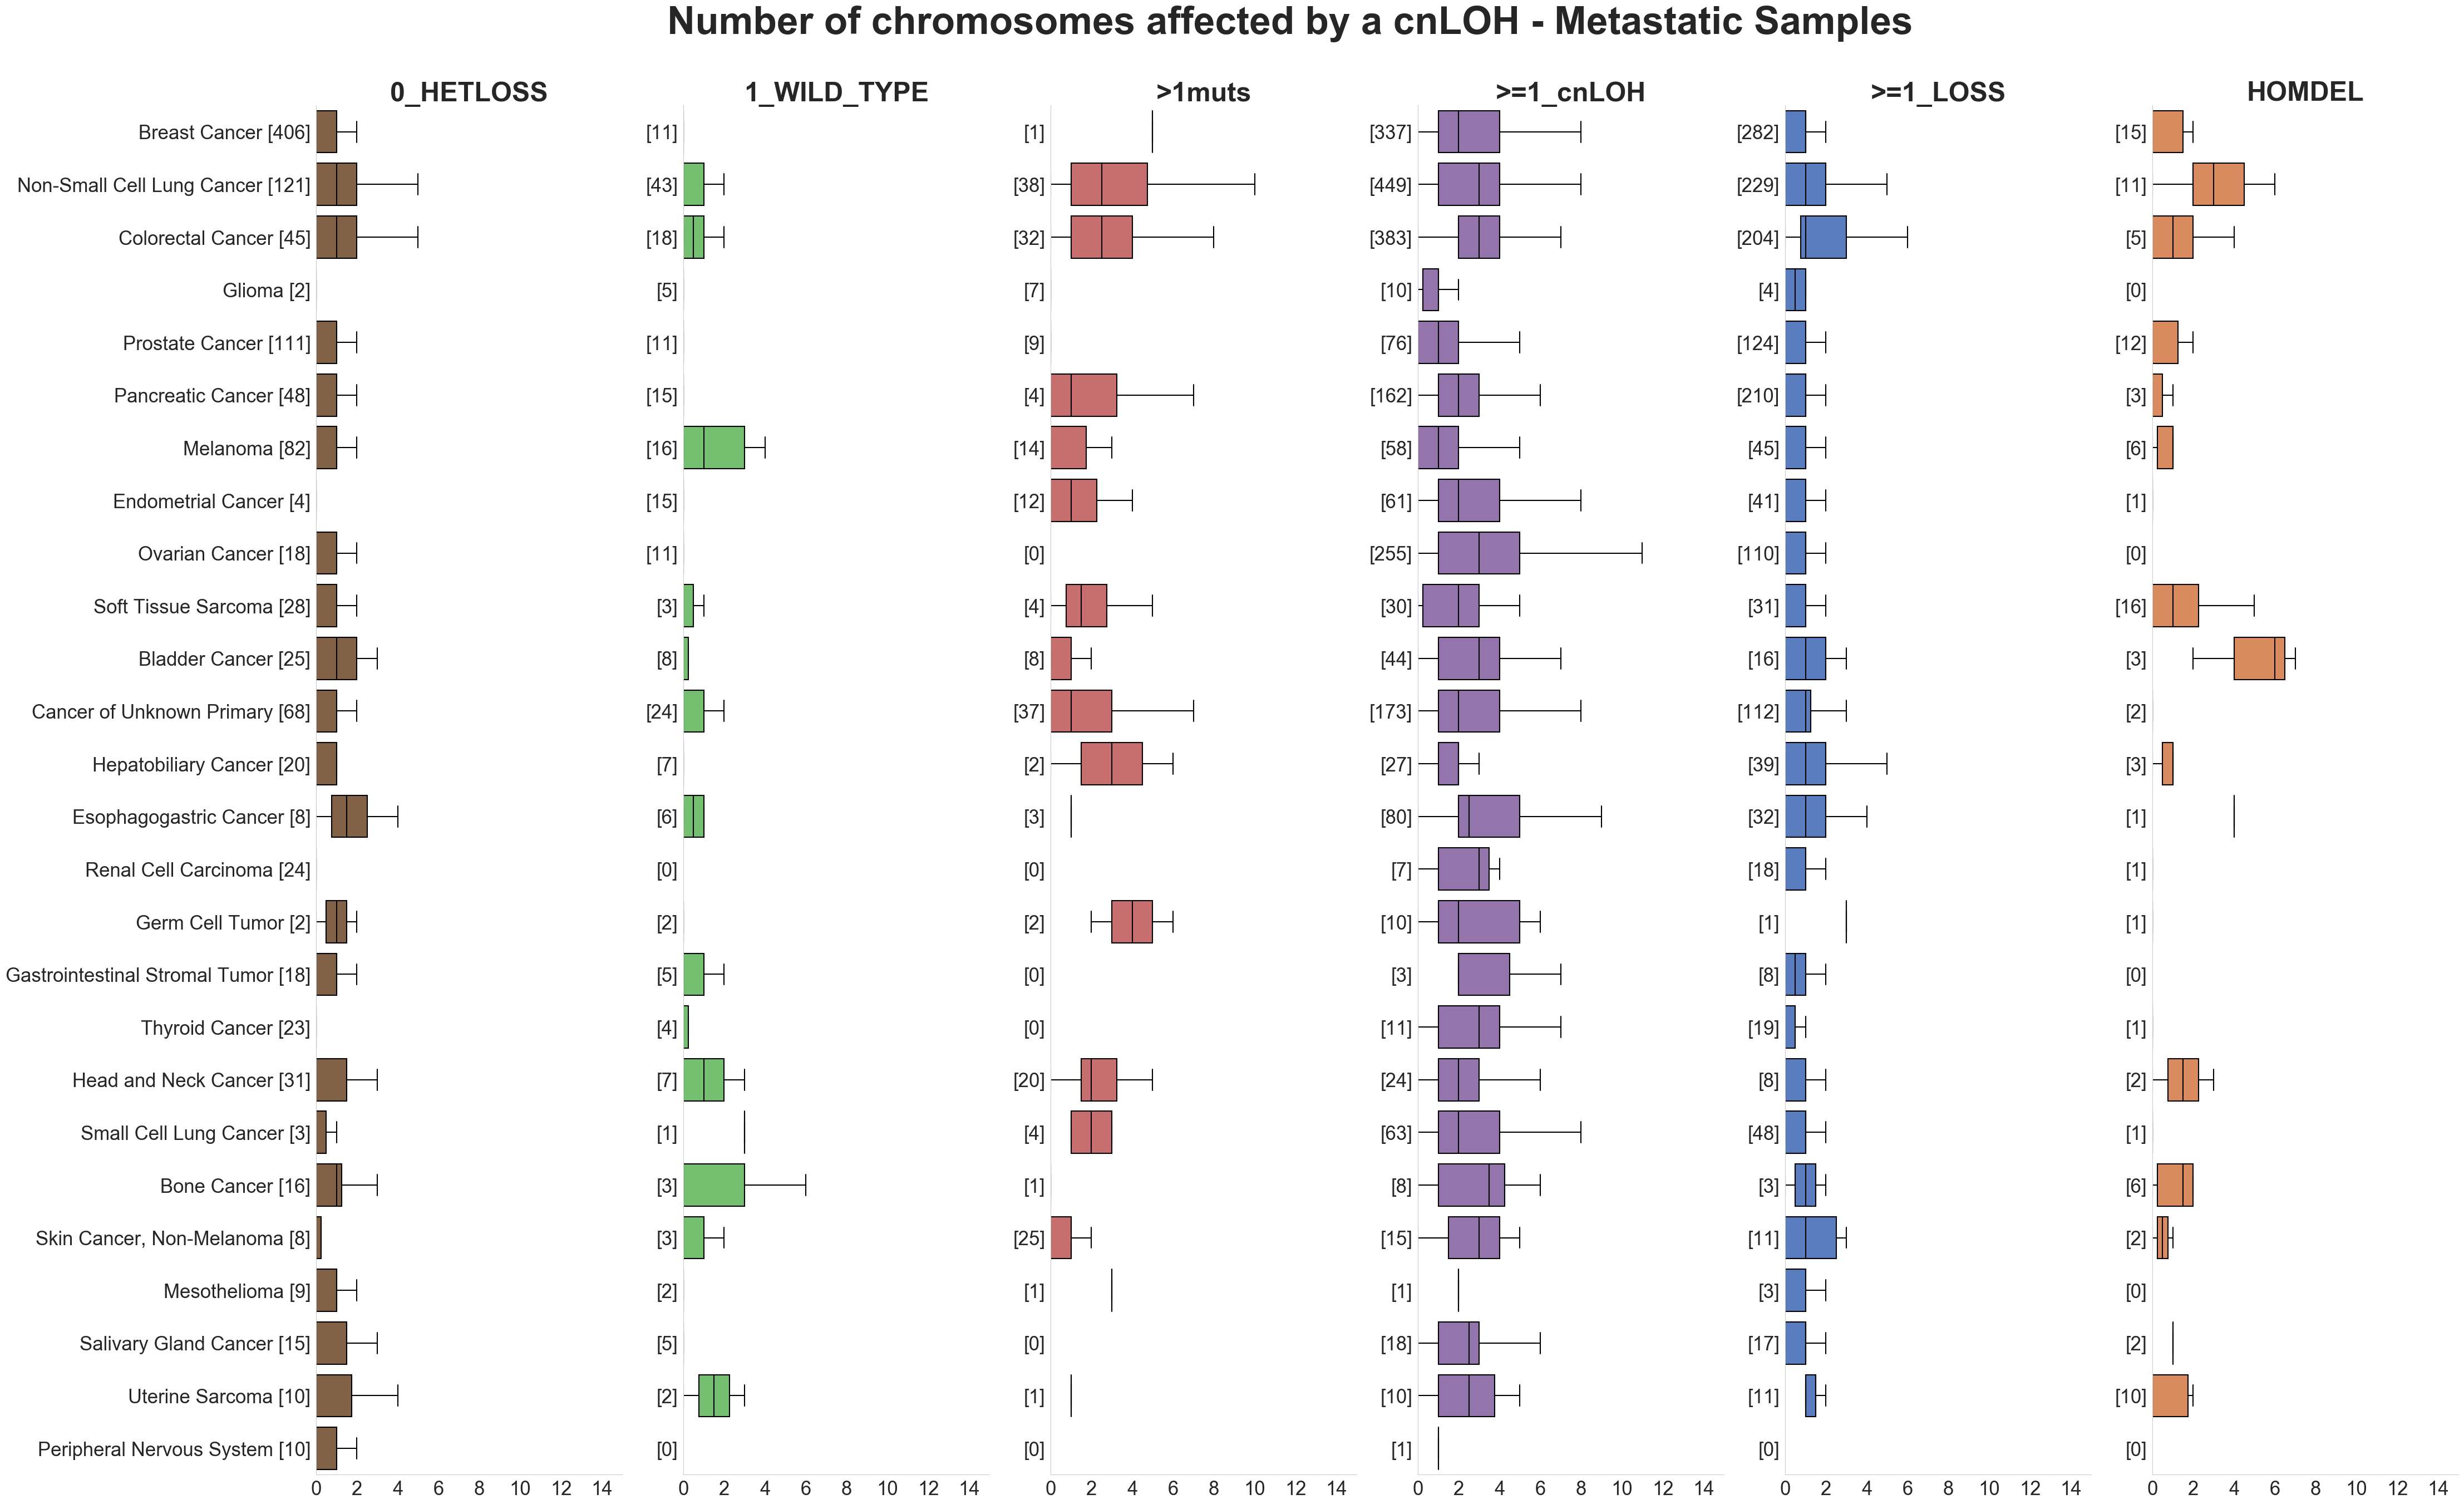

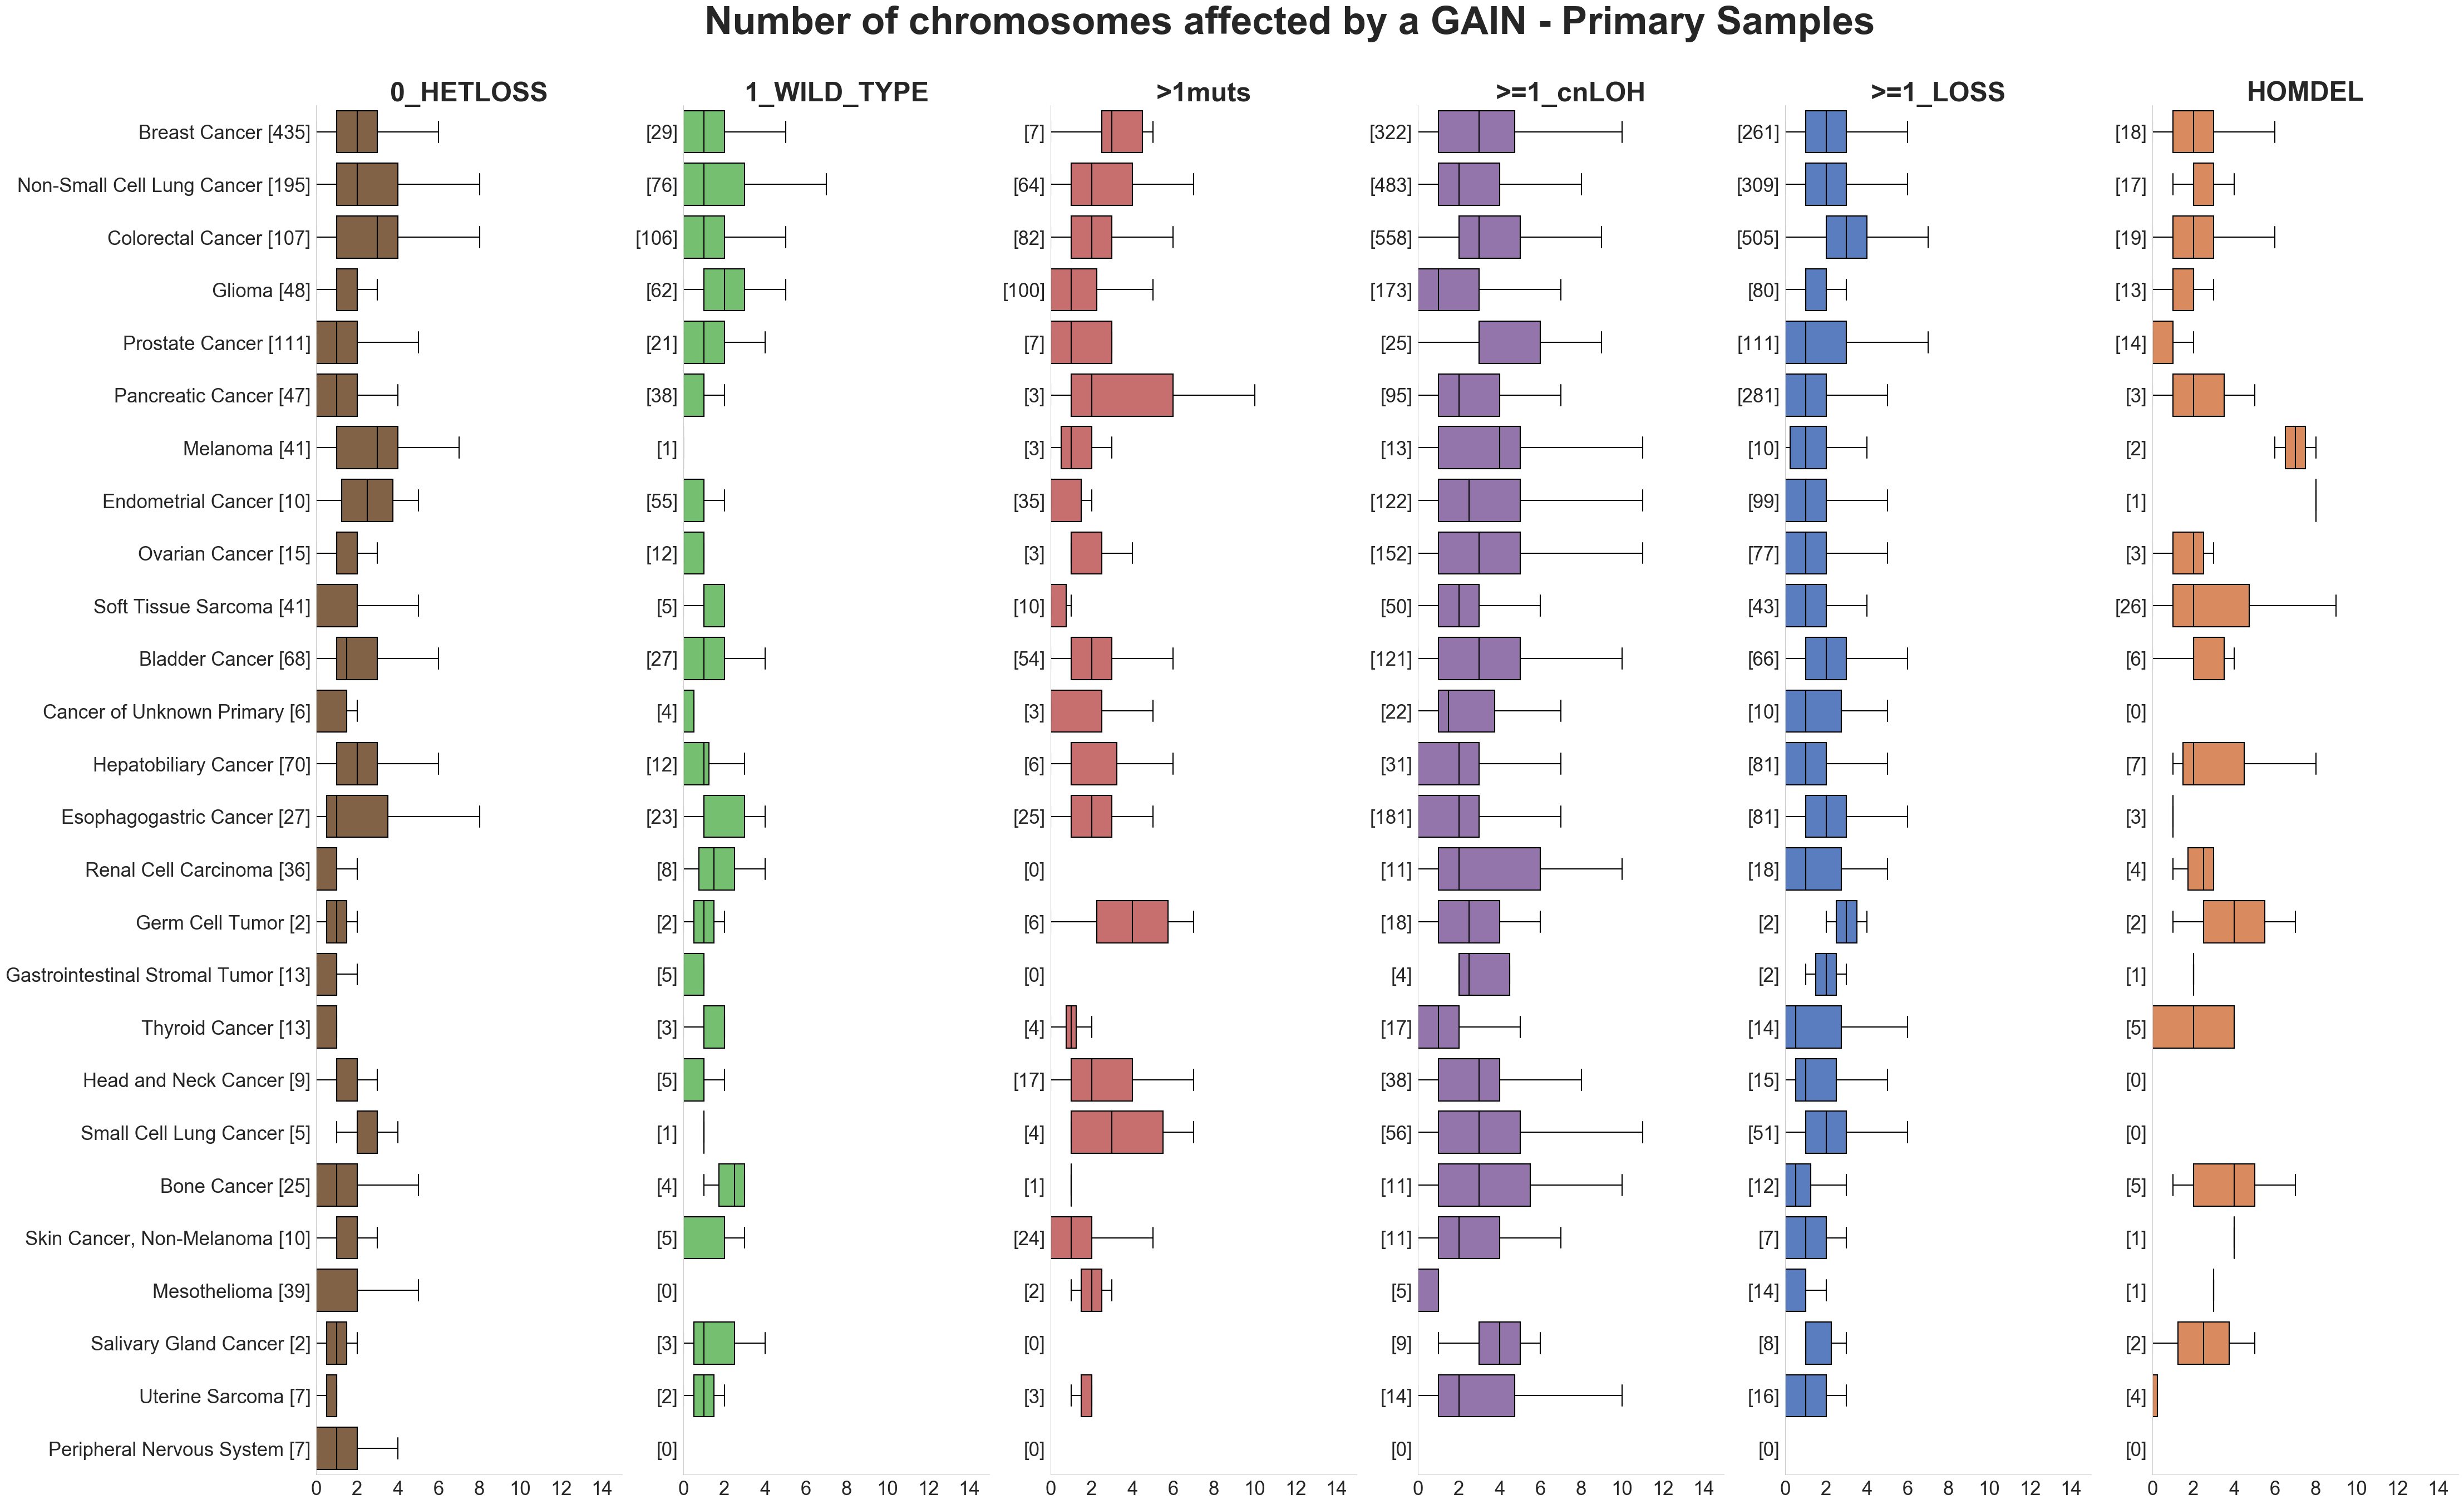

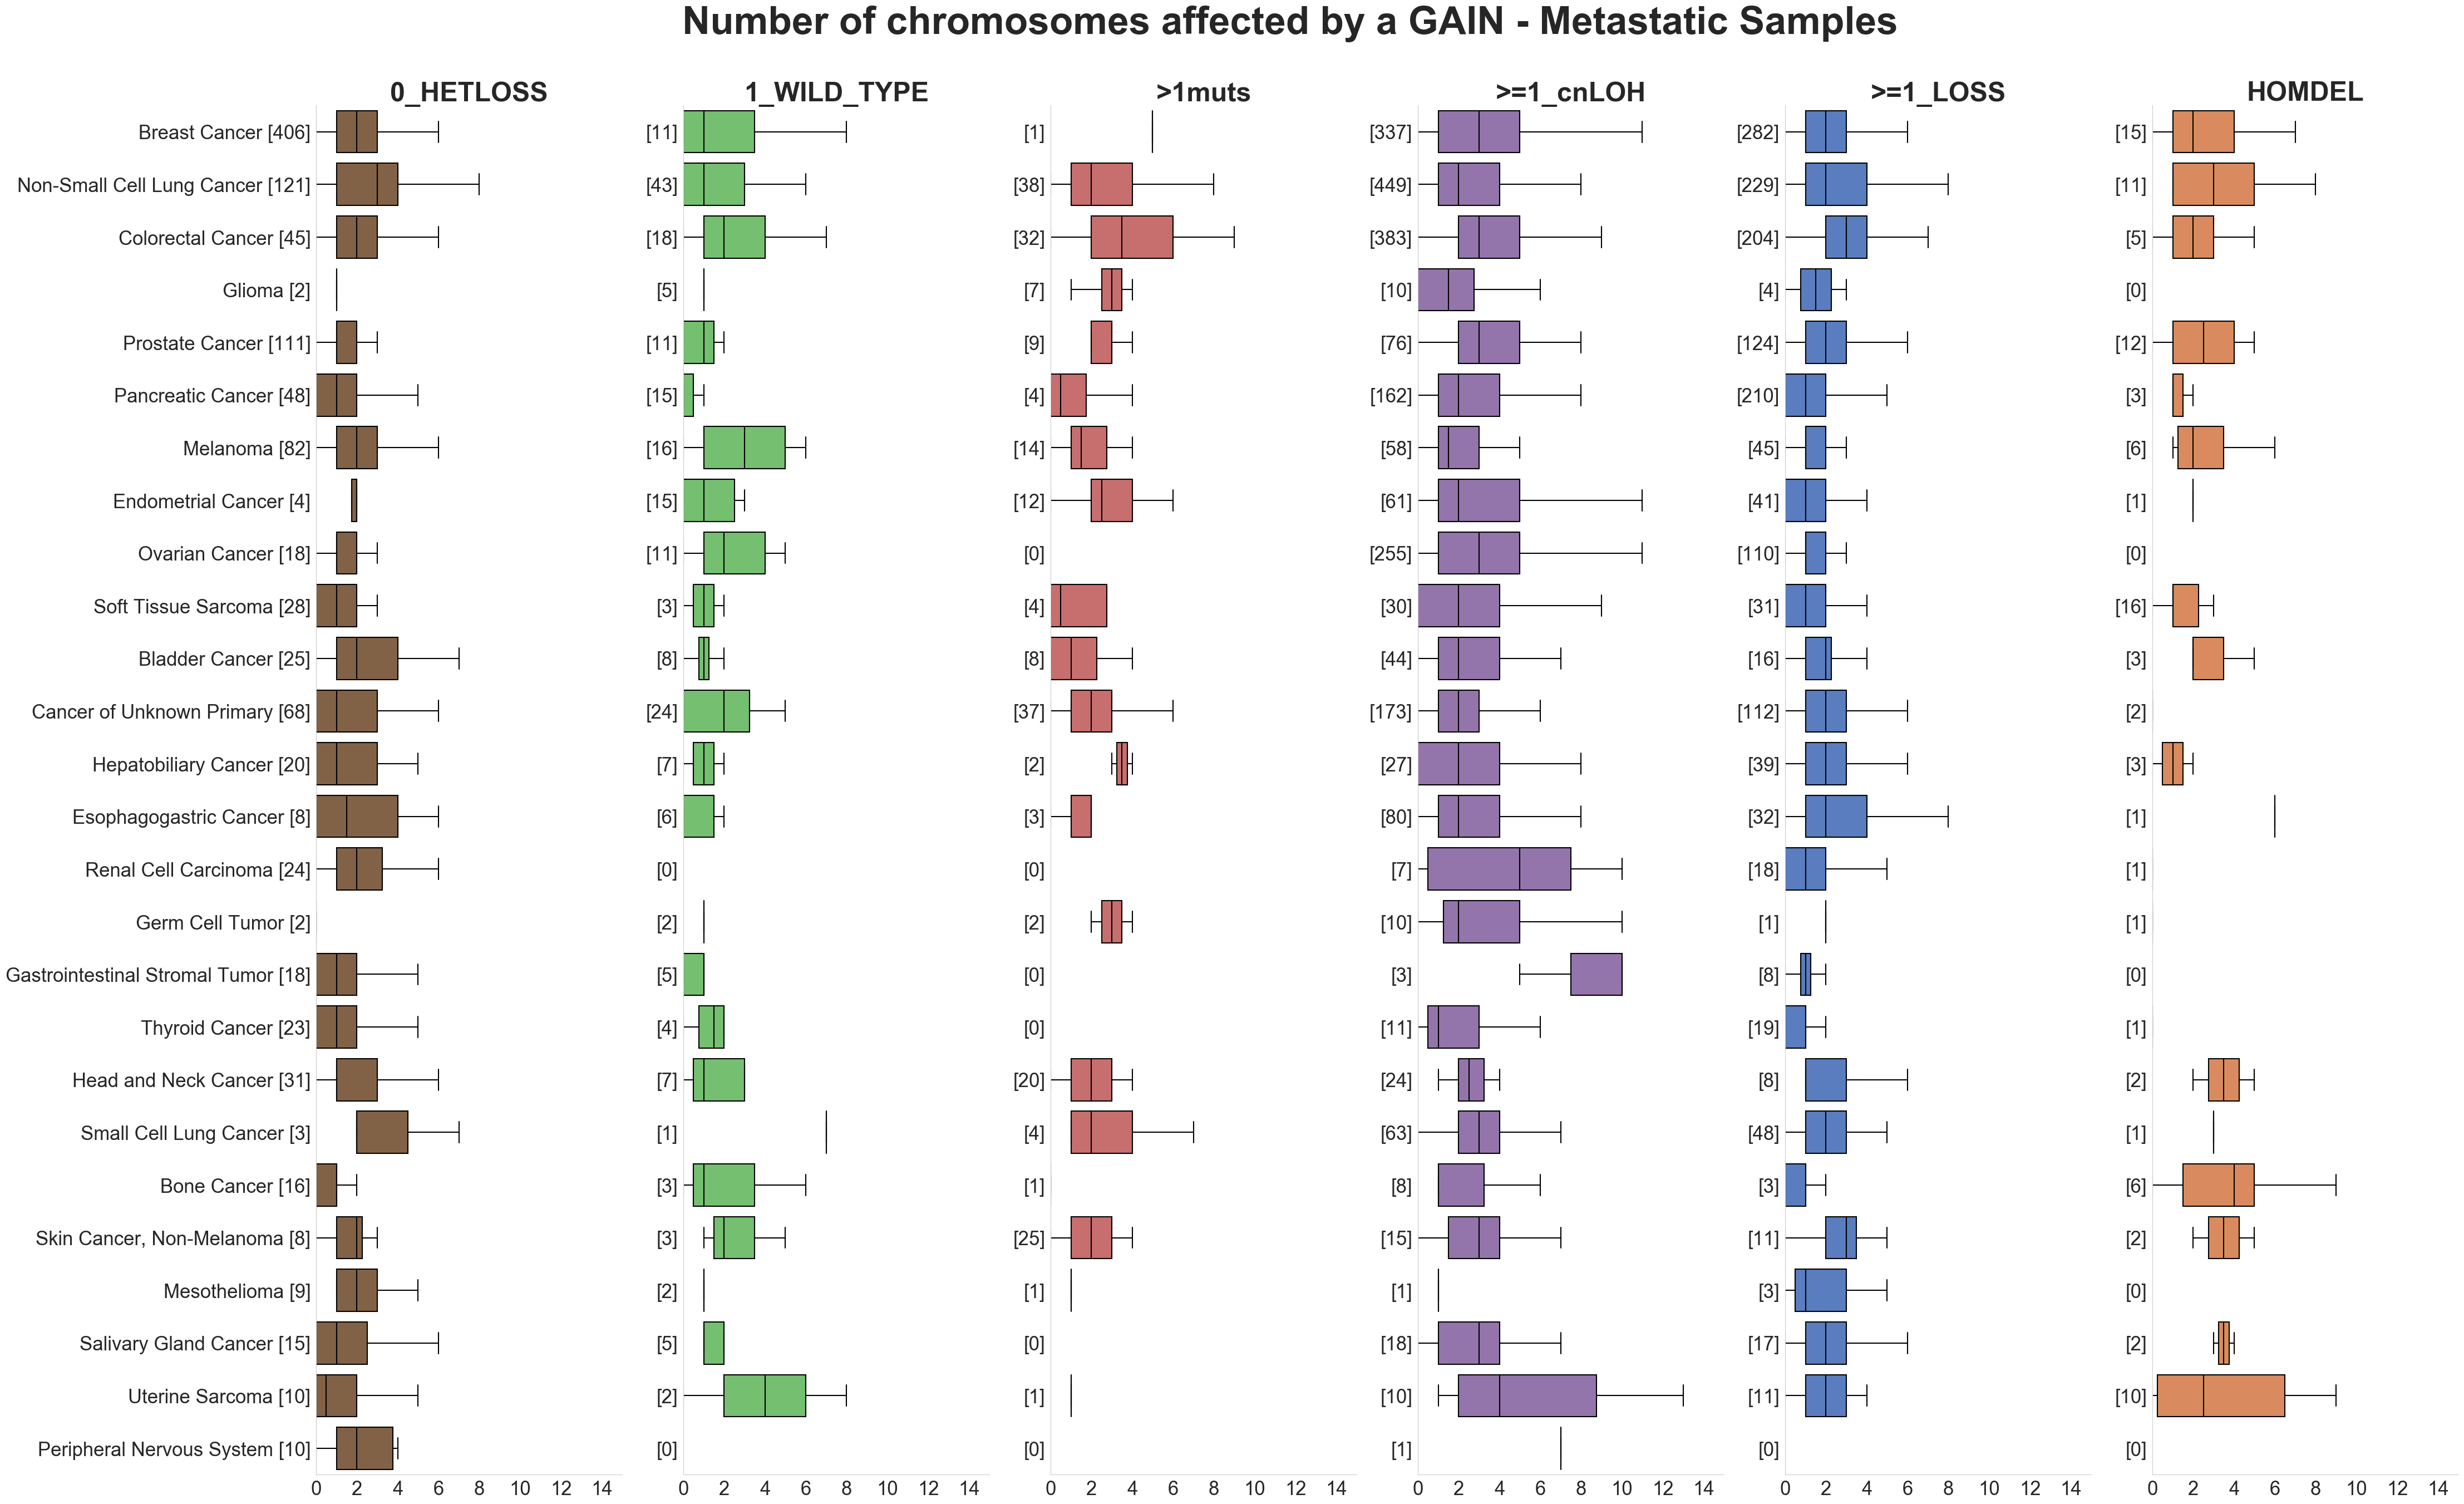

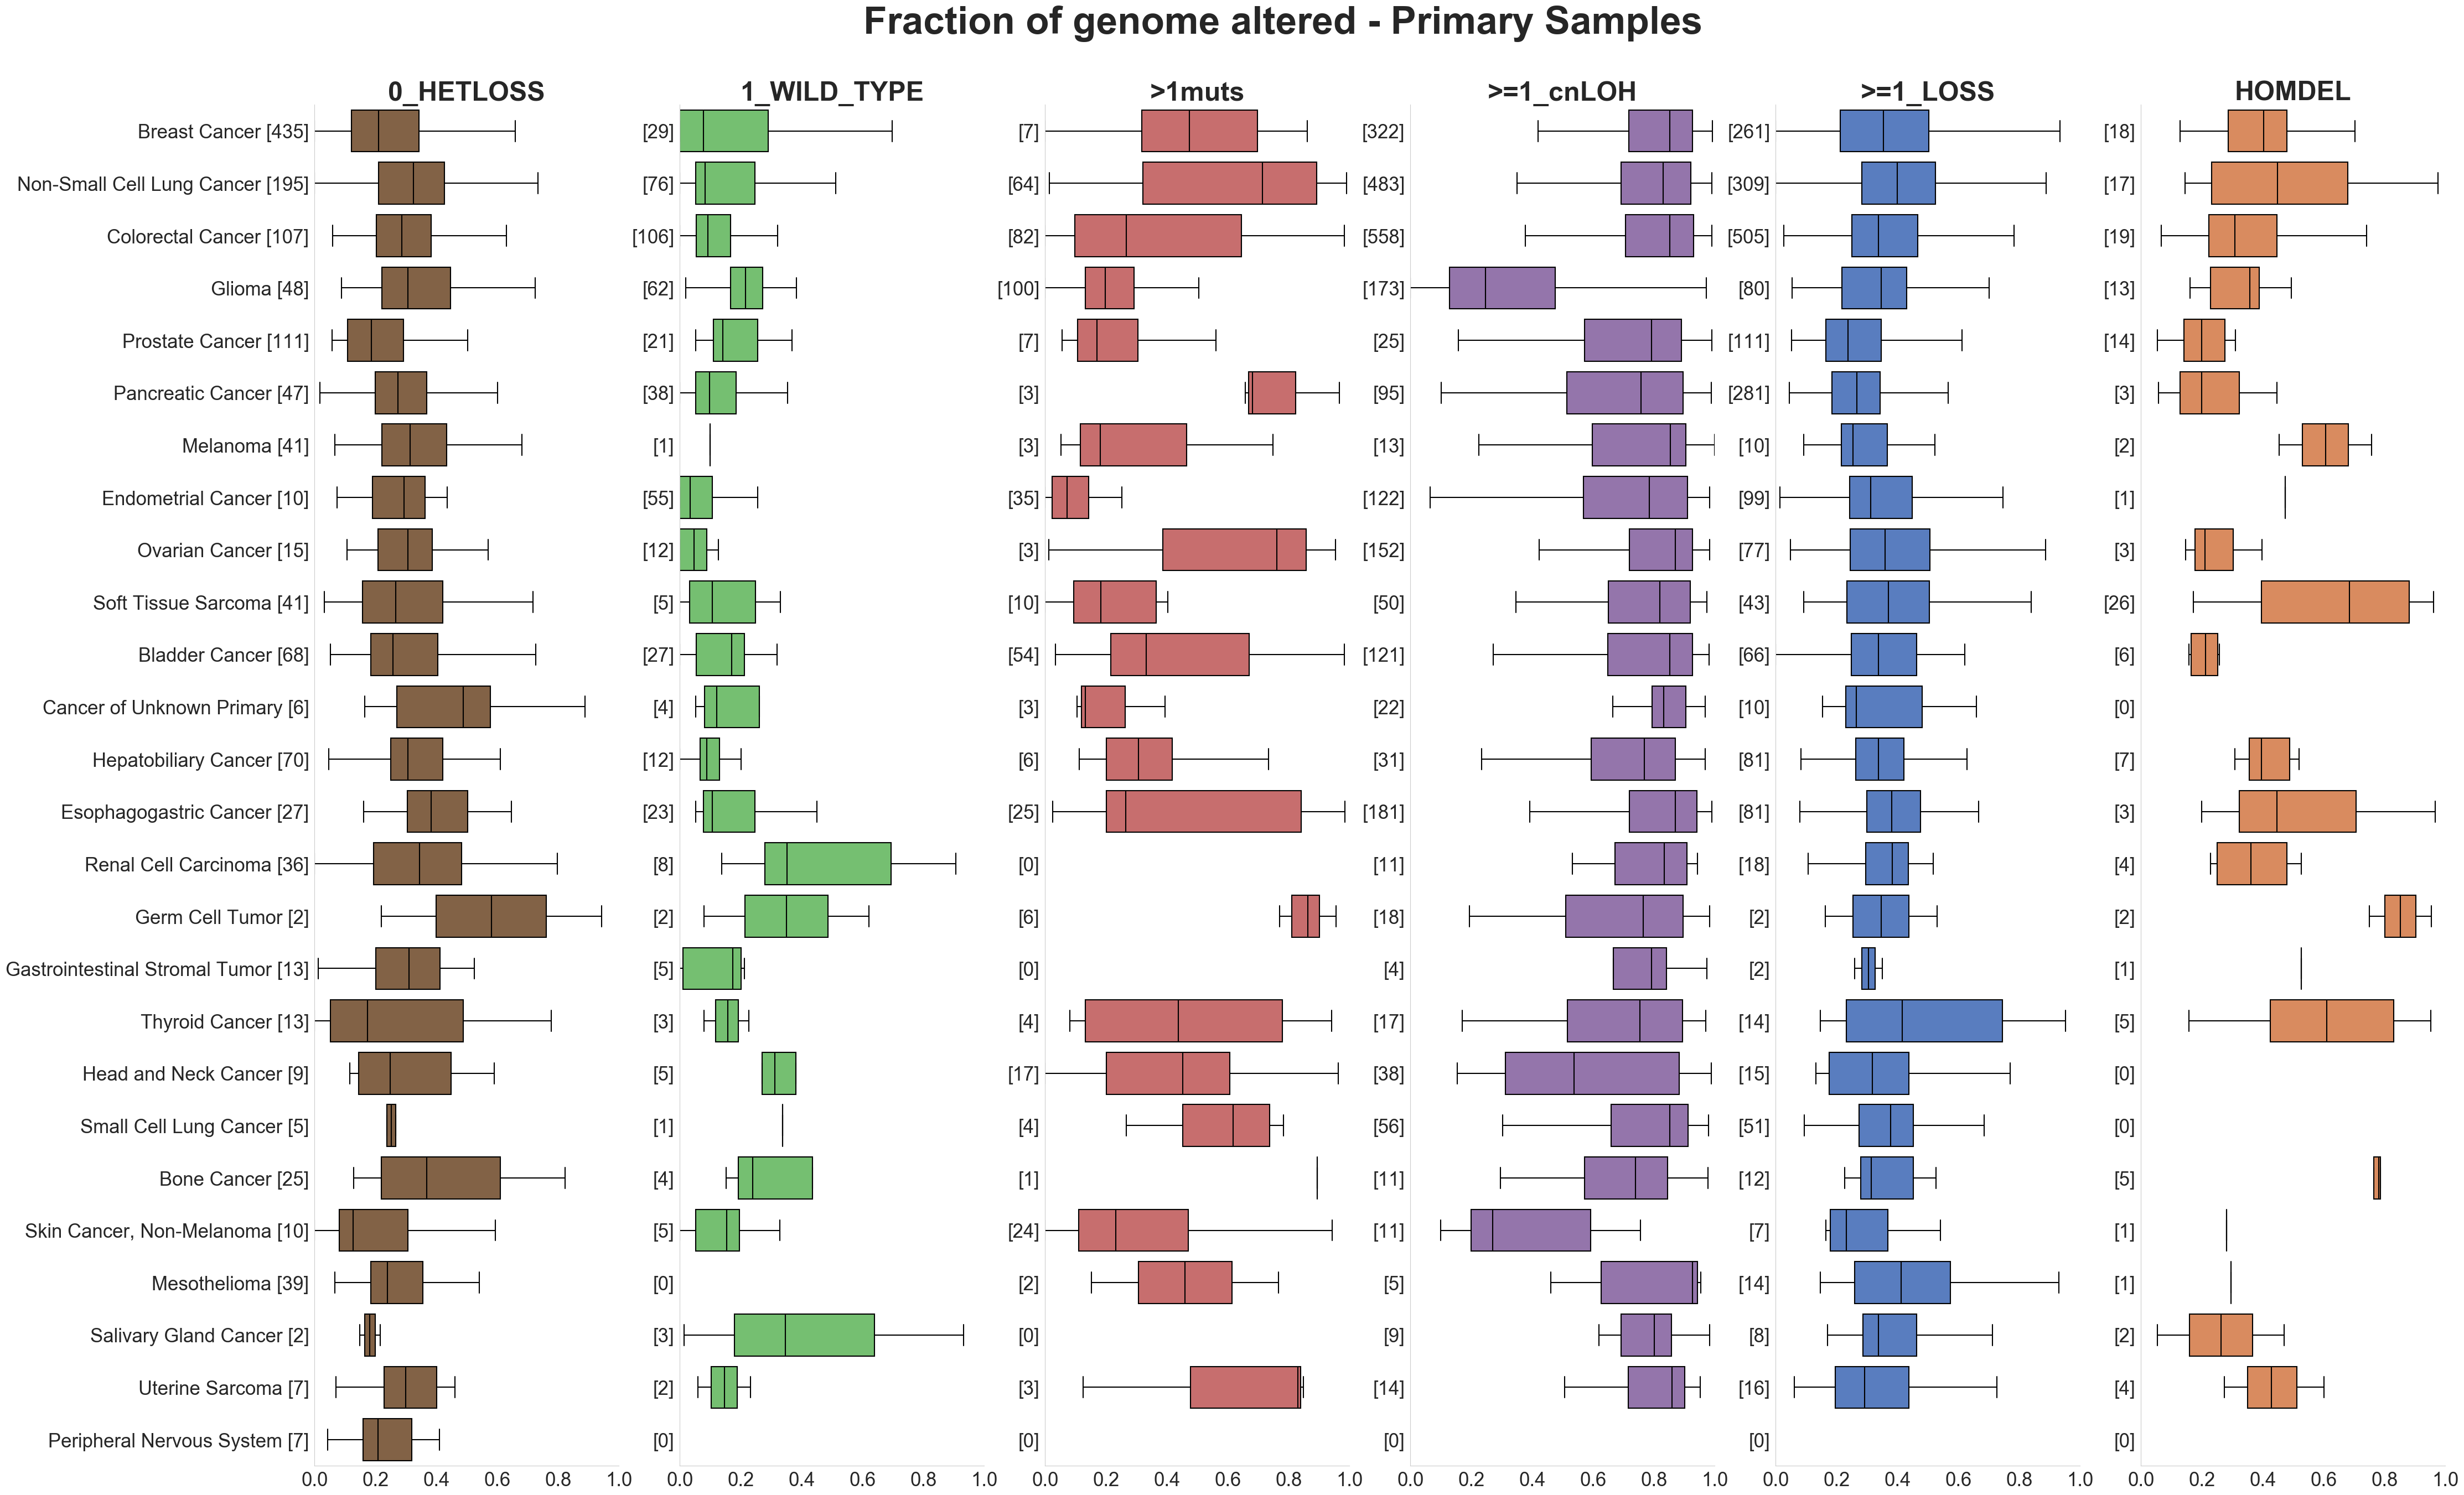

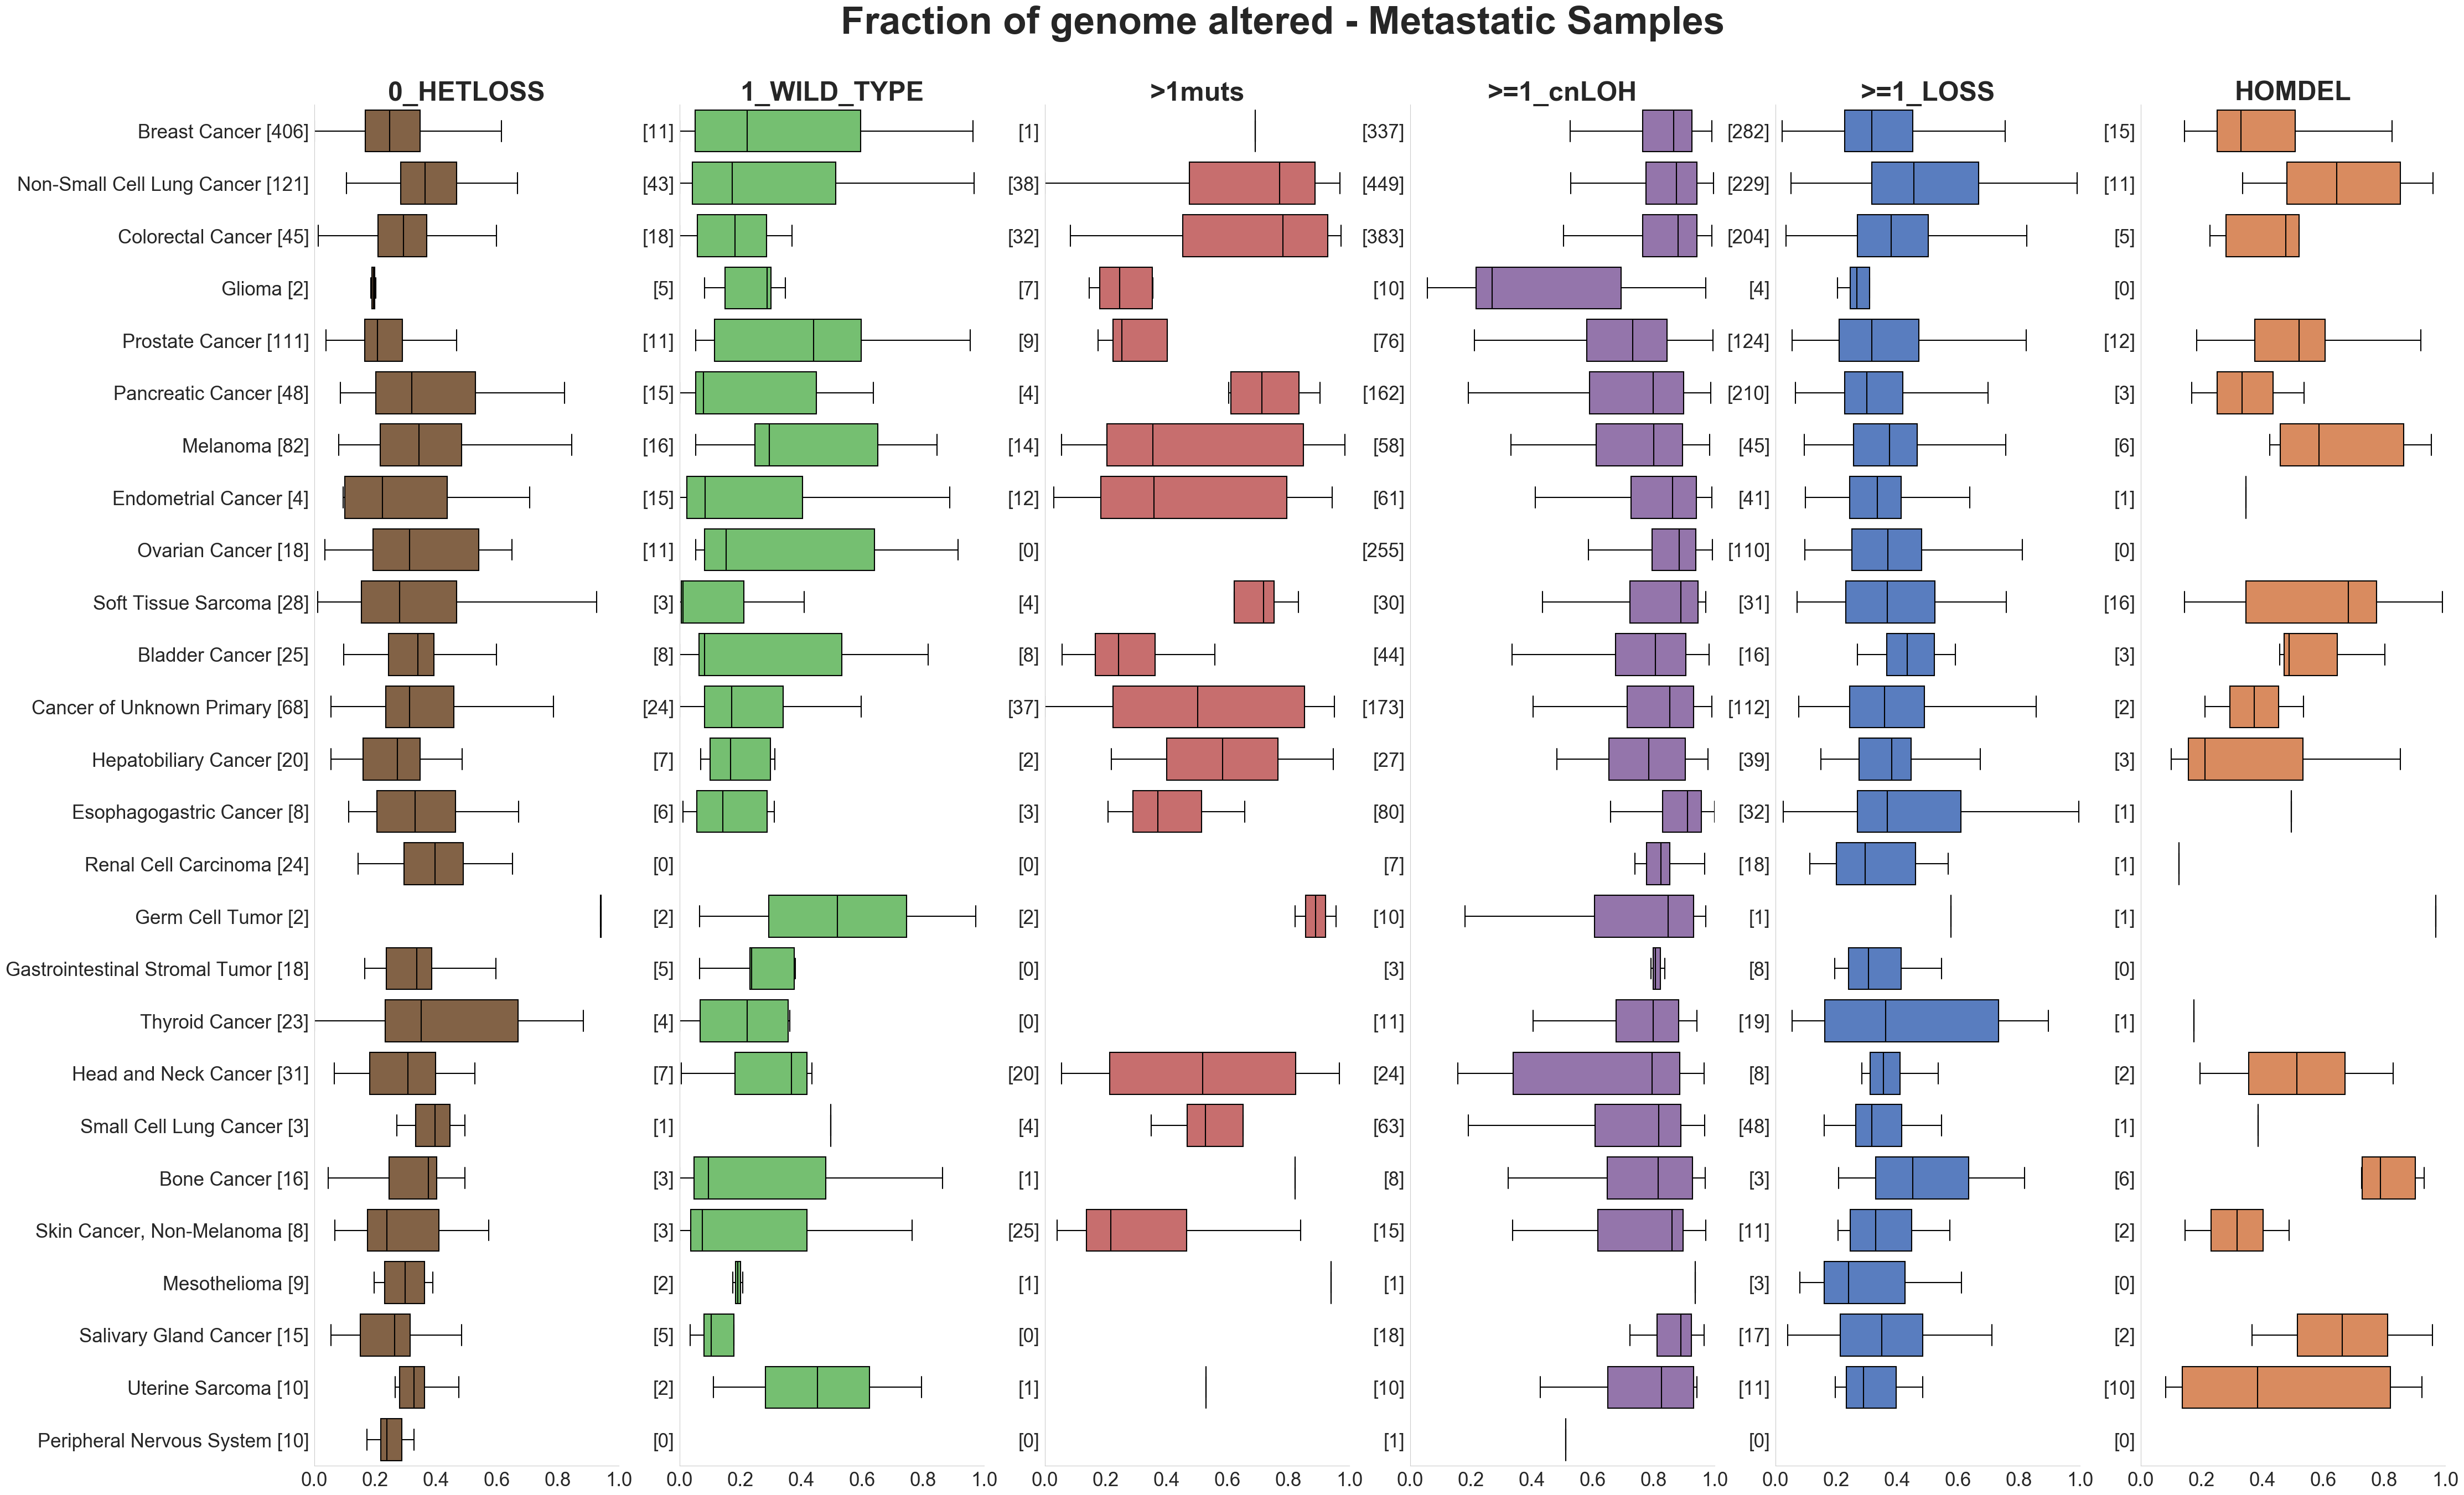

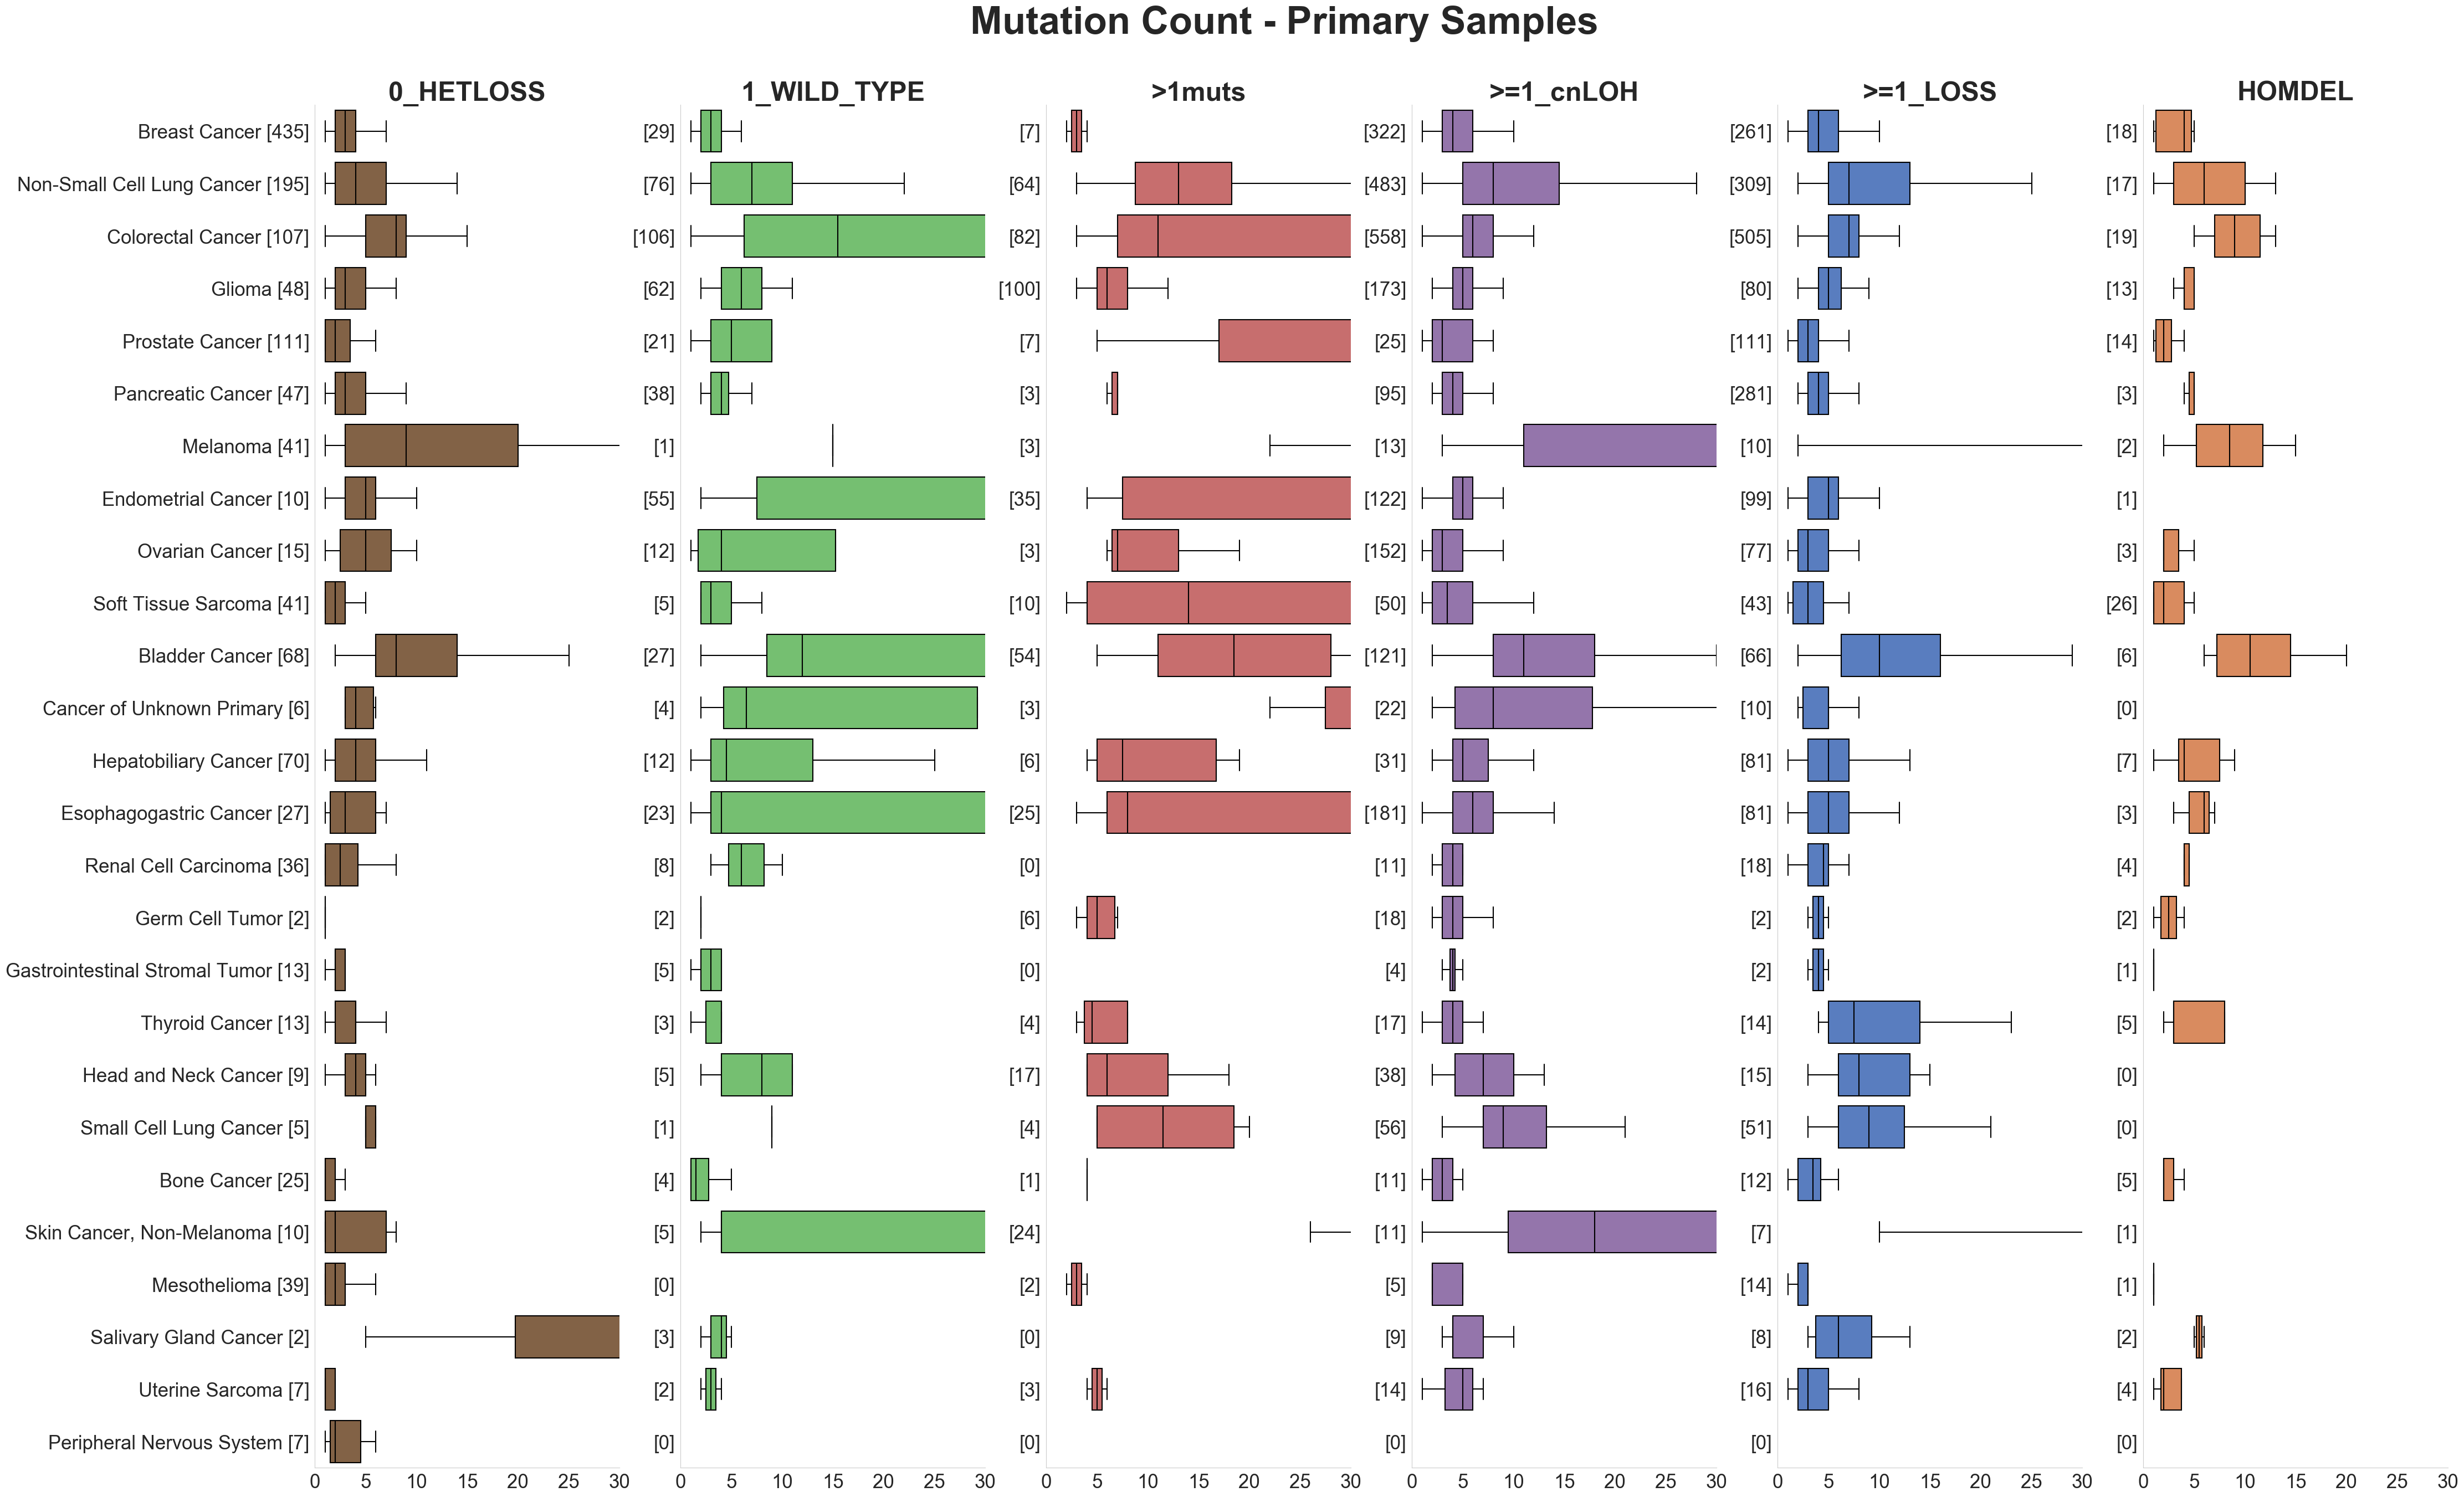

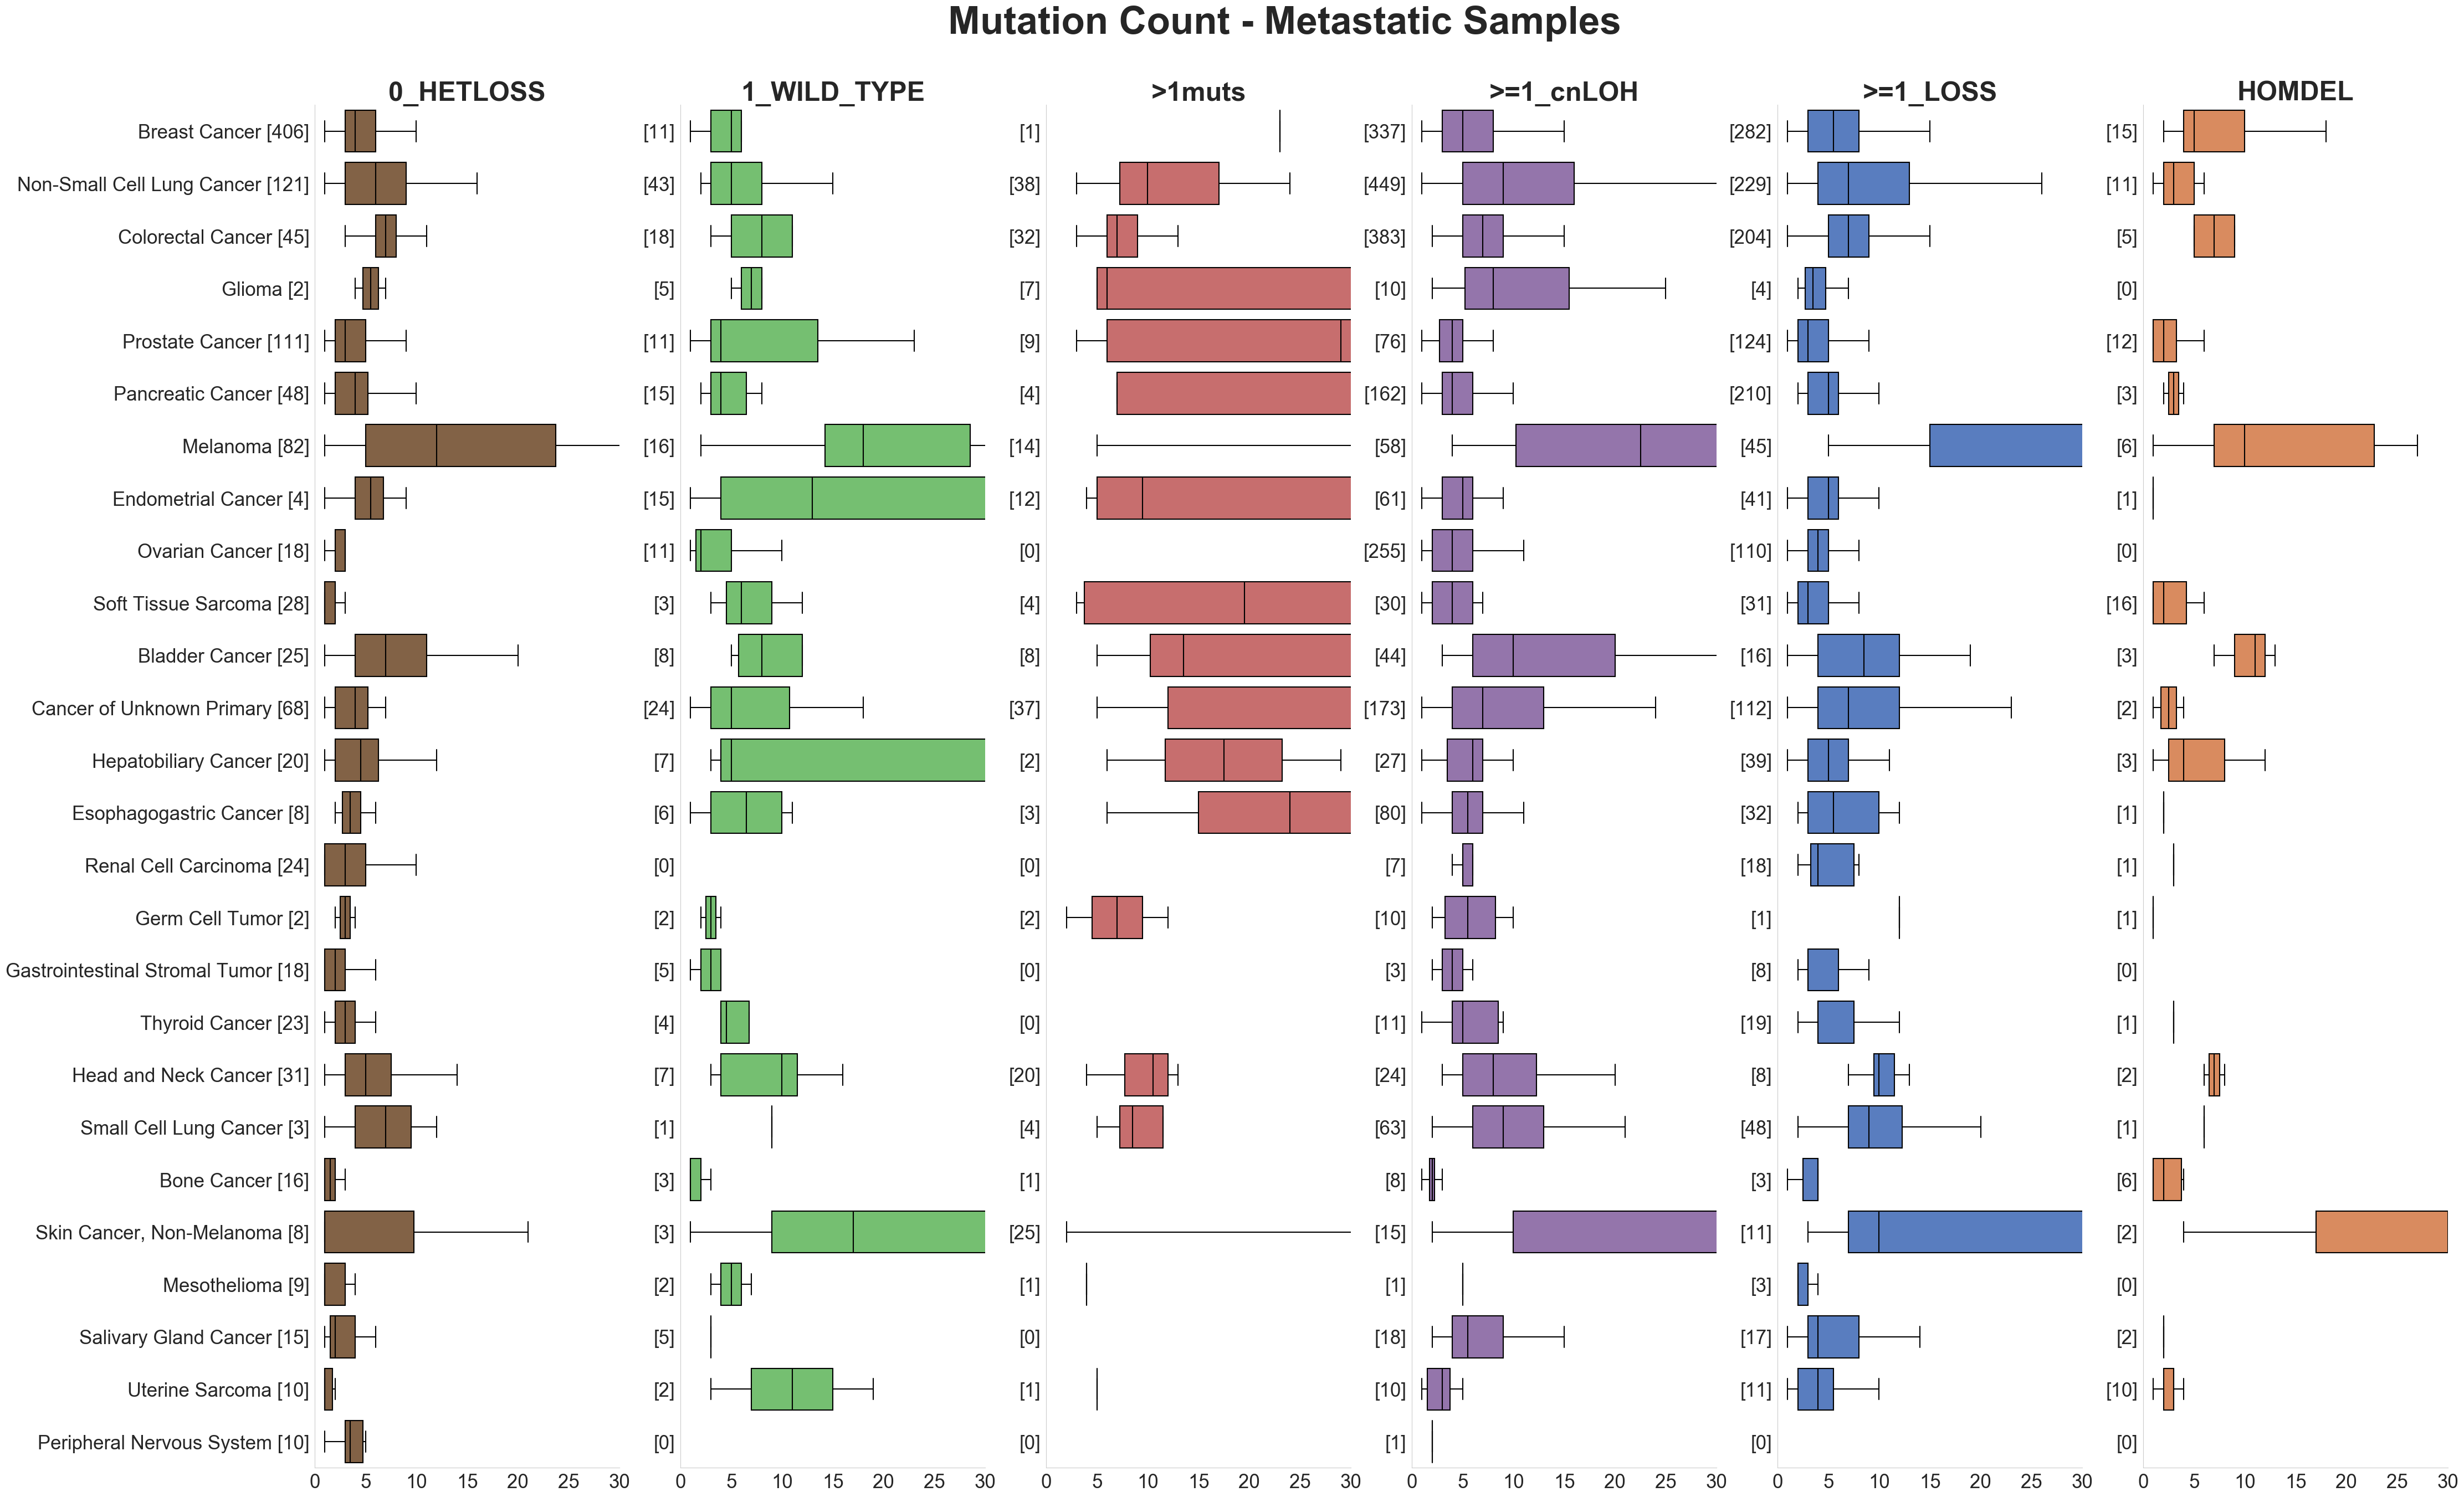

In [11]:
titles = ['Number of aberrant chromosomes - Primary Samples', 'Number of aberrant chromosomes - Metastatic Samples',
          'Number of chromosomes affected by a LOSS - Primary Samples', 'Number of chromosomes affected by a LOSS - Metastatic Samples',
          'Number of chromosomes affected by a cnLOH - Primary Samples','Number of chromosomes affected by a cnLOH - Metastatic Samples',
          'Number of chromosomes affected by a GAIN - Primary Samples','Number of chromosomes affected by a GAIN - Metastatic Samples',
          'Fraction of genome altered - Primary Samples','Fraction of genome altered - Metastatic Samples',
          'Mutation Count - Primary Samples','Mutation Count - Metastatic Samples']

group_choice='tp53_group'
i=0
for metrics in ['chr_affected', 'chr_loss', 'chr_cnloh', 'chr_gain', 'frac_genome_altered', 'mutation_count']:
    for prim_met in ['Primary', 'Metastasis']:
        if metrics in ['chr_loss', 'chr_cnloh', 'chr_gain']:
            if metrics == 'chr_loss':
                panel_metrics(group_choice=group_choice, 
                          metrics=metrics, 
                          title=titles[i], 
                          prim_met=prim_met, 
                          xlim=25)
            else: 
                panel_metrics(group_choice=group_choice, 
                          metrics=metrics, 
                          title=titles[i], 
                          prim_met=prim_met, 
                          xlim=15)
        elif metrics == 'frac_genome_altered':
            panel_metrics(group_choice=group_choice, 
                          metrics=metrics, 
                          title=titles[i], 
                          prim_met=prim_met, 
                          xlim=1)
        elif metrics=='mutation_count':
            panel_metrics(group_choice=group_choice, 
                          metrics=metrics, 
                          title=titles[i], 
                          prim_met=prim_met, 
                          xlim=30)
        else :
            panel_metrics(group_choice=group_choice, 
                          metrics=metrics, 
                          title=titles[i], 
                          prim_met=prim_met, 
                          xlim=25)
        i+=1

## Legend Plot

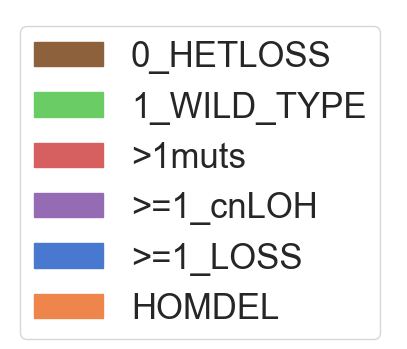

In [9]:
fig, ax = plt.subplots(figsize=(5,1))
# Create a color palette
group_list = ['0_HETLOSS', '1_WILD_TYPE', '>1muts', '>=1_cnLOH', '>=1_LOSS','HOMDEL']
palette_list = [mc[5],mc[2],mc[3],mc[4],mc[0],mc[1]]
palette = dict(zip(group_list, palette_list))
# Create legend handles manually
handles = [matplotlib.patches.Patch(color=palette[x], label=x) for x in palette.keys()]
# Create legend
ax.legend(handles=handles, fontsize=25, loc='centered')
# Get current axes object and turn off axis
ax.set_axis_off()
plt.show()

# Mutation Type comparison

# Merging all metrics panels in 1 PDF

In [12]:
import os
from PyPDF2 import PdfFileMerger

pdfs = os.listdir("./metrics_summaries/")
merger = PdfFileMerger()
for pdf in pdfs:
    if("pdf" in pdf):
          merger.append("./metrics_summaries/"+pdf)

merger.write("./ALL_METRICS_PANEL.pdf")
merger.close()